This notebook will implement changing lora settings and separate dataloader

In [1]:
# !pip install torch==2.1.1 torchaudio torchvision tqdm==4.66.1 accelerate==0.24.1 biopython==1.81 numpy==1.26.2 pandas==2.1.3 \
# transformers==4.35.2 datasets==2.15.0 scikit-learn==1.3.2 umap-learn==0.5.5 sentencepiece==0.1.99 seaborn==0.13.0 scipy==1.11.4 \
# matplotlib==3.8.2 evaluate==0.4.1 deepspeed==0.12.3

In [2]:
# try with UMAP

In [2]:
import os.path

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from torch.utils.data import DataLoader

import re
import numpy as np
import pandas as pd
import copy

import transformers, datasets
from transformers.modeling_outputs import SequenceClassifierOutput
# from transformers.models.t5.modeling_t5 import T5Config, T5PreTrainedModel, T5Stack
from transformers.utils.model_parallel_utils import assert_device_map, get_device_map
# from transformers import T5EncoderModel, T5Tokenizer
from transformers import TrainingArguments, Trainer, set_seed
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

from transformers import EsmModel, EsmConfig, EsmTokenizer


# Initializing a ESM facebook/esm-1b style configuration >>> configuration = EsmConfig()

# Initializing a model from the configuration >>> model = ESMModel(configuration)

# Accessing the model configuration >>> configuration = model.config

from evaluate import load
from datasets import Dataset

from tqdm import tqdm
import random

from scipy import stats
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt
#!pip install umap-learn
import umap

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
print("Torch version: ",torch.__version__)
print("Cuda version: ",torch.version.cuda)
print("Numpy version: ",np.__version__)
print("Pandas version: ",pd.__version__)
print("Transformers version: ",transformers.__version__)
print("Datasets version: ",datasets.__version__)

Torch version:  2.1.1+cu121
Cuda version:  12.1
Numpy version:  1.26.4
Pandas version:  2.2.2
Transformers version:  4.35.2
Datasets version:  2.19.1


In [4]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/train_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

local_fasta_path = '../src/input_datasets/train_Pos_Neg_Y.fasta'

for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|P24928|RPB1_HUMAN%1775%1791,NYTPTSPNYSPTSPSYSPTSPSYSPTSPSYSPS,1
1,sp|P05787|K2C8_HUMAN%58%74,SGMGGITAVTVNQSLLSPLVLEVDPNIQAVRTQ,1
2,sp|Q14832|GRM3_HUMAN%829%845,QPQKNVVTHRLHLNRFSVSGTGTTYSQSSASTY,1
3,sp|P01106|MYC_HUMAN%46%62,SEDIWKKFELLPTPPLSPSRRSGLCSPSYVAVT,1
4,sp|Q92736|RYR2_HUMAN%2792%2808,TREGDSMALYNRTRRISQTSQVSVDAAHGYSPR,1


In [6]:
# # Function to get the middle character
# def get_middle_char(sequence):
#     chars = list(sequence)
#     middle_index = len(chars) // 2
#     return chars[middle_index]

# # Apply the function to get the middle characters
# df['middle_char'] = df['sequence'].apply(get_middle_char)

In [7]:
# # Function to count 'S', 'T', 'Y' in a sequence
# def count_chars(sequence, char):
#     return sequence.count(char)

# # Count the occurrences of 'S', 'T', and 'Y' in the sequences
# df['count_S'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'S'))
# df['count_T'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'T'))
# df['count_Y'] = df['middle_char'].apply(lambda seq: count_chars(seq, 'Y'))

# # Sum the counts to get the total occurrences in the DataFrame
# total_S = df['count_S'].sum()
# total_T = df['count_T'].sum()
# total_Y = df['count_Y'].sum()

# print(f"Total number of 'S': {total_S}")
# print(f"Total number of 'T': {total_T}")
# print(f"Total number of 'Y': {total_Y}")

In [8]:
# # Group by label and sum the counts
# grouped_counts = df.groupby('label')[['count_S', 'count_T', 'count_Y']].sum().reset_index()

# # Display the grouped counts
# print(grouped_counts)

In [9]:
# # Separate the DataFrame by middle character
# df_S = df[df['middle_char'] == 'S']
# df_T = df[df['middle_char'] == 'T']
# df_Y = df[df['middle_char'] == 'Y']

# # Separate each subset by label
# df_S_0 = df_S[df_S['label'] == 0]
# df_S_1 = df_S[df_S['label'] == 1]
# df_T_0 = df_T[df_T['label'] == 0]
# df_T_1 = df_T[df_T['label'] == 1]
# df_Y_0 = df_Y[df_Y['label'] == 0]
# df_Y_1 = df_Y[df_Y['label'] == 1]


In [10]:
# from sklearn.utils import resample
# # Desired number of samples per group
# n_samples_S = 500
# n_sampple_T = 300
# n_sampple_Y = 200
# # Perform stratified sampling
# df_S_0_resampled = resample(df_S_0, replace=False, n_samples=n_samples_S, random_state=42)
# df_S_1_resampled = resample(df_S_1, replace=False, n_samples=n_samples_S, random_state=42)
# df_T_0_resampled = resample(df_T_0, replace=True, n_samples=n_sampple_T, random_state=42)
# df_T_1_resampled = resample(df_T_1, replace=True, n_samples=n_sampple_T, random_state=42)
# df_Y_0_resampled = resample(df_Y_0, replace=True, n_samples=n_sampple_Y, random_state=42)
# df_Y_1_resampled = resample(df_Y_1, replace=True, n_samples=n_sampple_Y, random_state=42)



In [11]:
# # Combine the resampled subsets
# balanced_df = pd.concat([
#     df_S_0_resampled, df_S_1_resampled,
#     df_T_0_resampled, df_T_1_resampled,
#     df_Y_0_resampled, df_Y_1_resampled
# ])

# # Shuffle the combined DataFrame
# balanced_df = balanced_df.sample(frac=1, random_state=42).reset_index(drop=True)

# print("Balanced DataFrame:")
# print(balanced_df)


In [12]:
# from sklearn.model_selection import train_test_split

# # Split the dataset into training and validation sets
# my_train, my_valid = train_test_split(
#     balanced_df, 
#     test_size=0.2, 
#     random_state=42, 
#     stratify=balanced_df[['label', 'middle_char']]
# )

# my_train=my_train[["sequence", "label"]]
# my_valid=my_valid[["sequence","label"]]


# # Print the first 5 rows of the training set
# print("Training Set:")
# print(my_train.shape)

# # Print the first 5 rows of the validation set
# print("\nValidation Set:")
# print(my_valid.shape)

In [5]:
from sklearn.model_selection import train_test_split

# Split the dataset into training and validation sets
my_train, my_valid = train_test_split(df, test_size=0.2, random_state=42)

my_train=my_train[["sequence", "label"]]
my_valid=my_valid[["sequence","label"]]


# Print the first 5 rows of the training set
print("Training Set:")
print(my_train.shape)

# Print the first 5 rows of the validation set
print("\nValidation Set:")
print(my_valid.shape)

Training Set:
(1584, 2)

Validation Set:
(396, 2)


In [6]:
# Modifies an existing transformer and introduce the LoRA layers

class LoRAConfig:
    def __init__(self, lora_rank=8, lora_init_scale=0.01, lora_scaling_rank=2):
        self.lora_rank = lora_rank
        self.lora_init_scale = lora_init_scale
        self.lora_modules = ".*SelfAttention|.*EncDecAttention"
        self.lora_layers = "q|k|v|o"
        self.trainable_param_names = ".*layer_norm.*|.*lora_[ab].*"
        self.lora_scaling_rank = lora_scaling_rank
        # lora_modules and lora_layers are specified with regular expressions
        # see https://www.w3schools.com/python/python_regex.asp for reference
        
class LoRALinear(nn.Module):
    def __init__(self, linear_layer, rank, scaling_rank, init_scale):
        super().__init__()
        self.in_features = linear_layer.in_features
        self.out_features = linear_layer.out_features
        self.rank = rank
        self.scaling_rank = scaling_rank
        self.weight = linear_layer.weight
        self.bias = linear_layer.bias
        if self.rank > 0:
            self.lora_a = nn.Parameter(torch.randn(rank, linear_layer.in_features) * init_scale)
            if init_scale < 0:
                self.lora_b = nn.Parameter(torch.randn(linear_layer.out_features, rank) * init_scale)
            else:
                self.lora_b = nn.Parameter(torch.zeros(linear_layer.out_features, rank))
        if self.scaling_rank:
            self.multi_lora_a = nn.Parameter(
                torch.ones(self.scaling_rank, linear_layer.in_features)
                + torch.randn(self.scaling_rank, linear_layer.in_features) * init_scale
            )
            if init_scale < 0:
                self.multi_lora_b = nn.Parameter(
                    torch.ones(linear_layer.out_features, self.scaling_rank)
                    + torch.randn(linear_layer.out_features, self.scaling_rank) * init_scale
                )
            else:
                self.multi_lora_b = nn.Parameter(torch.ones(linear_layer.out_features, self.scaling_rank))

    def forward(self, input):
        if self.scaling_rank == 1 and self.rank == 0:
            # parsimonious implementation for ia3 and lora scaling
            if self.multi_lora_a.requires_grad:
                hidden = F.linear((input * self.multi_lora_a.flatten()), self.weight, self.bias)
            else:
                hidden = F.linear(input, self.weight, self.bias)
            if self.multi_lora_b.requires_grad:
                hidden = hidden * self.multi_lora_b.flatten()
            return hidden
        else:
            # general implementation for lora (adding and scaling)
            weight = self.weight
            if self.scaling_rank:
                weight = weight * torch.matmul(self.multi_lora_b, self.multi_lora_a) / self.scaling_rank
            if self.rank:
                weight = weight + torch.matmul(self.lora_b, self.lora_a) / self.rank
            return F.linear(input, weight, self.bias)

    def extra_repr(self):
        return "in_features={}, out_features={}, bias={}, rank={}, scaling_rank={}".format(
            self.in_features, self.out_features, self.bias is not None, self.rank, self.scaling_rank
        )


def modify_with_lora(transformer, config):
    for m_name, module in dict(transformer.named_modules()).items():
        if re.fullmatch(config.lora_modules, m_name):
            for c_name, layer in dict(module.named_children()).items():
                if re.fullmatch(config.lora_layers, c_name):
                    assert isinstance(
                        layer, nn.Linear
                    ), f"LoRA can only be applied to torch.nn.Linear, but {layer} is {type(layer)}."
                    setattr(
                        module,
                        c_name,
                        LoRALinear(layer, config.lora_rank, config.lora_scaling_rank, config.lora_init_scale),
                    )
    return transformer

In [7]:
class ClassConfig:
    def __init__(self, dropout=0.7, num_labels=2):
        self.dropout_rate = dropout
        self.num_labels = num_labels

class ESMClassificationHead(nn.Module):
    """Head for sentence-level classification tasks."""

    def __init__(self, config, class_config):
        super().__init__()
        self.dense = nn.Linear(config.hidden_size, config.hidden_size)
        self.dropout = nn.Dropout(class_config.dropout_rate)
        self.out_proj = nn.Linear(config.hidden_size, class_config.num_labels)
   
        # Trainable emphasis factor
        self.emphasis_factor = nn.Parameter(torch.tensor(1.0))
        
    def forward(self, hidden_states):
        seq_length = hidden_states.size(1)
        middle_idx = seq_length // 2
        middle_embedding = hidden_states[:, middle_idx, :]

        # Apply trainable emphasis factor
        emphasized_middle_embedding = middle_embedding * self.emphasis_factor

        # Combine with the average embedding
        average_embedding = torch.mean(hidden_states, dim=1)
        combined_embedding = emphasized_middle_embedding + average_embedding

        x = self.dropout(combined_embedding)
        x = self.dense(x)
        x = torch.tanh(x)
        x = self.dropout(x)
        logits = self.out_proj(x)
        return logits
    
from transformers import PreTrainedModel, EsmModel, EsmConfig

class ESMForSequenceClassification(PreTrainedModel):
    config_class = EsmConfig

    def __init__(self, config: EsmConfig, class_config):
        super().__init__(config)
        self.num_labels = class_config.num_labels
        self.esm_model = EsmModel(config)
        self.classifier = ESMClassificationHead(config, class_config)
        self.init_weights()

    def forward(self, input_ids=None, attention_mask=None, labels=None):
        outputs = self.esm_model(input_ids, attention_mask=attention_mask)
        hidden_states = outputs.last_hidden_state

        logits = self.classifier(hidden_states)

        loss = None
        if labels is not None:
            if self.num_labels == 1:
                loss_fct = MSELoss()
                loss = loss_fct(logits.squeeze(), labels.squeeze())
            elif self.num_labels > 1 and labels.dtype in (torch.long, torch.int):
                loss_fct = CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            else:
                loss_fct = BCEWithLogitsLoss()
                loss = loss_fct(logits, labels)
        
        return SequenceClassifierOutput(
            loss=loss,
            logits=logits,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )

In [8]:
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer


def ESM_classification_model(num_labels, dropout, lora_rank, lora_init_scale, lora_scaling_rank):
    model_checkpoint = "facebook/esm2_t36_3B_UR50D"

    # Load PT5 and tokenizer
    tokenizer = EsmTokenizer.from_pretrained(model_checkpoint, cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
    model = EsmModel.from_pretrained(model_checkpoint, cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
    # model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
    # tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", do_lower_case=False, force_download=True) 
    
    # Create new Classifier model with PT5 dimensions
    class_config=ClassConfig(num_labels=num_labels, dropout=dropout)
    class_model = ESMForSequenceClassification(model.config, class_config)
    
    # # Set encoder and embedding weights to checkpoint weights
    # class_model.shared=model.shared
    # class_model.encoder=model.encoder    
    
    # # Delete the checkpoint model
    class_model.esm_model = model
    model=class_model
    del class_model
    
    # Print number of trainable parameters
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ESM_LoRA_Classfier\nTrainable Parameter: "+ str(params))    
 
    # Add model modification lora
    config = LoRAConfig(lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)
    
    # Add LoRA layers
    model = modify_with_lora(model, config)
    
    # Freeze Embeddings and Encoder (except LoRA)
    for (param_name, param) in model.named_parameters():
                param.requires_grad = False
    for (param_name, param) in model.classifier.named_parameters():
        param.requires_grad = True

    # for (param_name, param) in model.named_parameters():
    #         if re.fullmatch(config.trainable_param_names, param_name):
    #             param.requires_grad = True

    # Print trainable Parameter          
    model_parameters = filter(lambda p: p.requires_grad, model.parameters())
    params = sum([np.prod(p.size()) for p in model_parameters])
    print("ESM_LoRA_Classfier\nTrainable Parameter: "+ str(params) + "\n")
    
    return model, tokenizer

In [9]:
# Deepspeed config for optimizer CPU offload

ds_config = {
    "fp16": {
        "enabled": "auto",
        "loss_scale": 0,
        "loss_scale_window": 1000,
        "initial_scale_power": 16,
        "hysteresis": 2,
        "min_loss_scale": 1
    },

    "optimizer": {
        "type": "AdamW",
        "params": {
            "lr": "auto",
            "betas": "auto",
            "eps": "auto",
            "weight_decay": "auto"
        }
    },

    "scheduler": {
        "type": "WarmupLR",
        "params": {
            "warmup_min_lr": "auto",
            "warmup_max_lr": "auto",
            "warmup_num_steps": "auto"
        }
    },

    "zero_optimization": {
        "stage": 2,
        "offload_optimizer": {
            "device": "cpu",
            "pin_memory": True
        },
        "allgather_partitions": True,
        "allgather_bucket_size": 2e8,
        "overlap_comm": True,
        "reduce_scatter": True,
        "reduce_bucket_size": 2e8,
        "contiguous_gradients": True
    },

    "gradient_accumulation_steps": "auto",
    "gradient_clipping": "auto",
    "steps_per_print": 2000,
    "train_batch_size": "auto",
    "train_micro_batch_size_per_gpu": "auto",
    "wall_clock_breakdown": False
}

In [10]:
from transformers import TrainerCallback, TrainerState, TrainerControl

class EarlyStoppingCallback(TrainerCallback):
    """Custom early stopping callback that can monitor loss or accuracy."""
    
    def __init__(self, metric_name='eval_loss', early_stopping_patience=3, minimize=True):
        """
        Args:
            metric_name (str): Metric to monitor, default 'eval_loss'.
            early_stopping_patience (int): Number of checks with no improvement after which training will be stopped.
            minimize (bool): Set to True if the metric should be minimized, False if it should be maximized.
        """
        self.metric_name = metric_name
        self.early_stopping_patience = early_stopping_patience
        self.early_stopping_counter = 0
        self.minimize = minimize
        self.best_metric = float('inf') if minimize else float('-inf')
    
    def on_evaluate(self, args, state, control, **kwargs):
        current_metric = kwargs['metrics'][self.metric_name]
        
        if (self.minimize and current_metric < self.best_metric) or (not self.minimize and current_metric > self.best_metric):
            self.best_metric = current_metric
            self.early_stopping_counter = 0
        else:
            self.early_stopping_counter += 1
        
        if self.early_stopping_counter >= self.early_stopping_patience:
            control.should_training_stop = True
            print(f'Stopping early! No improvement in {self.metric_name} for {self.early_stopping_patience} evaluation steps.')


class MultiObjectiveEarlyStoppingCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        # Extract current validation loss and accuracy
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']

        # Check if current loss and accuracy improved significantly
        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            # Update best scores and reset wait time
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
        else:
            # If no improvement, increment the wait counter
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                # If wait exceeds the patience, stop training
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
class MultiObjectiveEarlyStoppingAndSaveCallback(TrainerCallback):
    def __init__(self, early_stopping_patience, min_delta=0.001, output_dir='./model_output', filename='finetuned_model'):
        self.early_stopping_patience = early_stopping_patience
        self.min_delta = min_delta
        self.best_val_loss = float('inf')
        self.best_val_accuracy = float('-inf')
        self.wait = 0
        self.output_dir = output_dir
        self.filename = filename
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)

    def on_evaluate(self, args, state: TrainerState, control: TrainerControl, **kwargs):
        val_loss = kwargs['metrics']['eval_loss']
        val_accuracy = kwargs['metrics']['eval_accuracy']
        model = kwargs['model']

        loss_improved = (self.best_val_loss - val_loss) > self.min_delta
        accuracy_improved = (val_accuracy - self.best_val_accuracy) > self.min_delta

        if loss_improved or accuracy_improved:
            self.best_val_loss = min(self.best_val_loss, val_loss)
            self.best_val_accuracy = max(self.best_val_accuracy, val_accuracy)
            self.wait = 0
            # Save the model as the best so far
            self.save_finetuned_parameters(model, os.path.join(self.output_dir, self.filename))
            print(f"Saved improved model to {self.output_dir}/{self.filename}")
        else:
            self.wait += 1
            if self.wait >= self.early_stopping_patience:
                control.should_training_stop = True
                print(f"Stopping early at epoch {state.epoch}: No improvement in loss or accuracy for {self.early_stopping_patience} evaluations.")
                
    def save_finetuned_parameters(self, model, filepath):
        # Create a dictionary to hold the non-frozen parameters
        non_frozen_params = {n: p for n, p in model.named_parameters() if p.requires_grad}
        # Save only the finetuned parameters 
        torch.save(non_frozen_params, filepath)

In [11]:
from sklearn.metrics import accuracy_score
#!pip install seaborn
import seaborn as sns
import gc

# Set random seeds for reproducibility of your trainings run
def set_seeds(s):
    torch.manual_seed(s)
    np.random.seed(s)
    random.seed(s)
    set_seed(s)

def apply_umap(embeddings, n_components=2, min_dist=0.01):
    umap_model = umap.UMAP(n_components=n_components)
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

def plot_umap(embeddings, labels):
    data = {"UMAP1": embeddings[:, 0], "UMAP2": embeddings[:, 1], "Label": labels}
    df = pd.DataFrame(data)
    
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9)
    plt.title("UMAP Visualization of Embeddings")
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_new.pdf")
    plt.show()
    
# Main training fuction
def train_per_protein(
        train_dataset,         #training data
        valid_dataset,         #validation data      
        weight_decay,
        warmup_pct,
        num_labels= 2,    #1 for regression, >1 for classification
    
        # effective training batch size is batch * accum
        # we recommend an effective batch size of 8 
        batch= 4,         #for training
        accum= 2,         #gradient accumulation
    
        val_batch = 16,   #batch size for evaluation
        epochs=1,       #training epochs
        lr= 3e-4,         #recommended learning rate
        seed= 42,         #random seed
        deepspeed=False,  #if gpu is large enough disable deepspeed for training speedup
        gpu= 1,
        dropout=0.5, #dropout rate
         #L2 weight regularization
        lora_rank=4,      #lora rank
        lora_init_scale=0.01, #lora scaling rank
        lora_scaling_rank=1,       #lora a
        ):         #gpu selection (1 for first gpu)

    # Set gpu device
    os.environ["CUDA_VISIBLE_DEVICES"]=str(gpu-1)
    
    # Set all random seeds
    set_seeds(seed)
    
    # load model
    model, tokenizer = ESM_classification_model(num_labels=num_labels, dropout=dropout, lora_rank=lora_rank, lora_init_scale=lora_init_scale, lora_scaling_rank=lora_scaling_rank)
    # model_checkpoint = "facebook/esm2_t36_3B_UR50D"
    # tokenizer = EsmTokenizer.from_pretrained(model_checkpoint, cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
    # model = EsmModel.from_pretrained(model_checkpoint, cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)

    # Huggingface Trainer arguments
    total_steps = epochs * len(train_dataset) // batch
    warmup_steps = int(warmup_pct * total_steps)
     
    # Define TrainingArguments
    args = TrainingArguments(
        output_dir='./results',              # where to save the model
        evaluation_strategy='epoch',         # evaluation is done at the end of each epoch
        logging_strategy='epoch',
        save_strategy='no',
        learning_rate=lr,                    # initial learning rate
        per_device_train_batch_size=batch,   # batch size per device
        gradient_accumulation_steps=accum,   # gradient accumulation steps
        num_train_epochs=epochs,             # number of epochs to train
        weight_decay=weight_decay,           # L2 weight regularization
        warmup_steps=warmup_steps,           # 10% of total steps
        load_best_model_at_end=False,         # load the best model at the end of training
        seed=seed,                           # random seed
        push_to_hub=False,                   # if you want to push model to the hub (Hugging Face Model Hub)
        logging_dir='./logs',
    )
    # metric_for_best_model='eval_loss|accuracy'

    # Metric definition for validation data
    def compute_metrics(eval_pred):
        predictions, labels = eval_pred.predictions, eval_pred.label_ids
        # Check if predictions have the expected shape
        if isinstance(predictions, tuple):
            predictions = predictions[0]
        if predictions.ndim > 1 and predictions.shape[1] > 1:
            predictions = np.argmax(predictions, axis=1)
        # Now, compute the metric (e.g., accuracy)
        accuracy = accuracy_score(labels, predictions)
        
        # Return the metric(s) as a dictionary
        return {"accuracy": accuracy}
    
    # For minimizing loss
    early_stopping_loss = EarlyStoppingCallback(metric_name='eval_loss', early_stopping_patience=3, minimize=True)

    # For maximizing accuracy
    early_stopping_accuracy = EarlyStoppingCallback(metric_name='eval_accuracy', early_stopping_patience=3, minimize=False)
    # Trainer          
    trainer = Trainer(
        model,
        args,
        train_dataset=train_dataset,
        eval_dataset=valid_dataset,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
        callbacks=[MultiObjectiveEarlyStoppingAndSaveCallback(
            early_stopping_patience=3,
            min_delta=0.001,
            output_dir='./model_output',
            filename='finetuned_model_all_esm2.pth'
        )],
    )    

    def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
        embeddings = []
        model = model.to(device)
        model.eval()
    
        # Iterate over the sequences in batches
        for i in range(0, len(sequences), batch_size):
            # Extract a batch of sequences
            batch = sequences[i:i + batch_size]
    
            # Tokenize the batch using the specified tokenizer and convert to PyTorch tensors
            inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    
            with torch.no_grad():
                # Forward pass through the model to obtain outputs
                outputs = model(**inputs)
    
            # Extract hidden states from the second-to-last layer (penultimate layer)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
    
            # Take the embeddings from the second-to-last layer
            embeddings_from_layer = hidden_states[:, 0, :]
    
            # Extend the list with the generated embeddings
            embeddings.extend(embeddings_from_layer)
    
            print(f"Batch {i // batch_size + 1}, Second-to-Last Layer Embeddings Shape: {embeddings_from_layer.shape}")
    
        return np.array(embeddings)

        
    # Train model
    trainer.train()

    # Get the best model
    # model = trainer.model
    # Ensure the best model is loaded
    best_model_path = os.path.join('./model_output', 'finetuned_model_all_esm2.pth')
    if os.path.exists(best_model_path):
        state_dict = torch.load(best_model_path)
        model.load_state_dict(state_dict, strict=False)
        print(f"Loaded best model from {best_model_path}")
        
    # Evaluate the best model
    eval_results = trainer.evaluate()
    print(eval_results)
    
    # Print the current learning rate
    # current_lr = trainer.optimizer.param_groups[0]['lr']
    # print(f"Current learning rate: {current_lr}")
    
    # valid_sequences = list(valid_dataset['sequence'])
    # valid_embeddings = get_embeddings(model, tokenizer, valid_sequences)

    # # Apply UMAP for dimensionality reduction
    # umap_embeddings = apply_umap(valid_embeddings)

    # # Plot UMAP embeddings
    # labels = list(valid_dataset['label'])
    # plot_umap(umap_embeddings, labels)
    
    torch.cuda.empty_cache()
    gc.collect()

    return tokenizer, model, trainer.state.log_history


In [12]:
# Dataset creation
def create_dataset(tokenizer,seqs,labels):
    tokenized = tokenizer(seqs, max_length=1024, padding=True, truncation=True)
    dataset = Dataset.from_dict(tokenized)
    dataset = dataset.add_column("labels", labels)

    return dataset

# Initialize the tokenizer
model_checkpoint = "facebook/esm2_t36_3B_UR50D"
tokenizer = EsmTokenizer.from_pretrained(model_checkpoint, cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
# tokenizer = T5Tokenizer.from_pretrained("Rostlab/prot_t5_xl_bfd", cache_dir="/home/ubuntu/data/hai/huggingface_cache/", do_lower_case=False, force_download=True) 

train_df = my_train
valid_df = my_valid

# Preprocess inputs
# Replace uncommon AAs with "X"
train_df["sequence"]=train_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
valid_df["sequence"]=valid_df["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
# Add spaces between each amino acid for PT5 to correctly use them
train_df['sequence']=train_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)
valid_df['sequence']=valid_df.apply(lambda row : " ".join(row["sequence"]), axis = 1)

# Create Datasets
train_set=create_dataset(tokenizer,list(train_df['sequence']),list(train_df['label']))
valid_set=create_dataset(tokenizer,list(valid_df['sequence']),list(valid_df['label']))

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [24]:
%rm all_dephos_withLORA_datasetloader.sqlite3

lr 0.0003459380673689418
batch 4
accum 4
dropout_rate 0.6303139405233136
weight_decay 7.145415686725527e-05
warmup_pct 0.12121786012551566
lora_rank 20
lora_init_scale 0.004413381171295235
lora_scaling_rank 3

In [24]:
# torch.cuda.empty_cache()

In [13]:
tokenizer, model, history = train_per_protein(train_set, valid_set, num_labels=2, batch=4, accum=4, epochs=20, seed=42, lr=0.0003459380673689418, dropout=0.6303139405233136, weight_decay=7.145415686725527e-05, warmup_pct=0.12121786012551566, lora_rank=20, lora_init_scale=0.004413381171295235, lora_scaling_rank=3)

Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:07<00:00,  4.00s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.706800,0.642258,0.704545
2,0.648500,0.584324,0.709596
3,0.601200,0.550624,0.729798
4,0.567000,0.545805,0.719697
5,0.553400,0.528095,0.734848
6,0.562000,0.539324,0.727273
7,0.562800,0.544778,0.727273
8,0.550300,0.523778,0.729798
9,0.535300,0.531071,0.739899
10,0.524700,0.548785,0.732323


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 12.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


Stopping early at epoch 12.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5310714244842529, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 8.6859, 'eval_samples_per_second': 45.591, 'eval_steps_per_second': 5.756, 'epoch': 12.0}


In [12]:
import optuna

def objective(trial):
    # Hyperparameters to be optimized
    # Updated to use suggest_float with log=True for loguniform distribution
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    batch = trial.suggest_categorical('batch', [1, 2, 4, 8])
    accum = trial.suggest_categorical('accum', [2, 4, 8])
    # Updated to use suggest_float for uniform distribution
    dropout = trial.suggest_float('dropout_rate', 0.1, 0.9)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-3, log=True)
    warmup_pct = trial.suggest_float("warmup_pct", 0.01, 0.3)  # Warmup percentage between 1% and 30%
    lora_rank = trial.suggest_int('lora_rank', 4, 32, step=4)
    lora_init_scale = trial.suggest_float('lora_init_scale', 1e-4, 1e-1, log=True)
    lora_scaling_rank = trial.suggest_int('lora_scaling_rank', 1, 8)


    # Training and evaluation
    tokenizer, model, history = train_per_protein(
        train_dataset=train_set, 
        valid_dataset=valid_set, 
        num_labels=2, 
        batch=batch, 
        accum=accum, 
        epochs=10,  # Fewer epochs for the trial runs
        lr=lr,
        dropout=dropout,
        weight_decay=weight_decay,
        warmup_pct=warmup_pct,
        lora_rank=lora_rank,
        lora_init_scale=lora_init_scale,
        lora_scaling_rank=lora_scaling_rank,
    )
    
    # Clear GPU memory
    # torch.cuda.empty_cache()
    
    print("History: ", history)
    
    # Extract the last validation accuracy from the history
    val_accuracy = [entry['eval_accuracy'] for entry in history if 'eval_accuracy' in entry][-1]
    val_loss = [entry['eval_loss'] for entry in history if 'eval_loss' in entry][-1]
    return val_loss, val_accuracy

directions=['minimize', 'maximize']  # Set the direction to maximize the validation accuracy, can also be 'minimize'
study = optuna.create_study(directions=directions,
                            storage="sqlite:///all_dephos_withLORA_esm2_10epochs.sqlite3",  # Specify the storage URL here.
                            study_name="all_dephos_withLORA_esm2_10epochs")
study.optimize(objective, n_trials=50)  # Adjust the number of trials based on your computational resources

# Analyzing results
pareto_front = study.best_trials  # Get the Pareto front (best non-dominated solutions)
for trial in pareto_front:
    print(f"Loss: {trial.values[0]}, Accuracy: {trial.values[1]}")  # Note the negation of accuracy

# print("Best trial:")
# print("  Value: ", study.best_trial.value)
# print("  Params: ")
# for key, value in study.best_trial.params.items():
#     print(f"    {key}: {value}")


[I 2024-06-09 17:26:58,506] A new study created in RDB with name: all_dephos_withLORA_esm2_10epochs
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.12s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.778900,0.689405,0.520202
2,0.788500,0.675592,0.676768
3,0.761900,0.659121,0.684343
4,0.733200,0.645654,0.707071
5,0.737900,0.634749,0.709596
6,0.737200,0.627298,0.714646
7,0.716100,0.622683,0.699495
8,0.705200,0.619486,0.707071
9,0.716700,0.617758,0.712121
10,0.717500,0.617190,0.709596


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 17:56:50,700] Trial 0 finished with values: [0.6177577972412109, 0.7121212121212122] and parameters: {'lr': 1.2096477090251053e-05, 'batch': 2, 'accum': 2, 'dropout_rate': 0.8862958691740843, 'weight_decay': 1.220828584650883e-05, 'warmup_pct': 0.1391730308918508, 'lora_rank': 20, 'lora_init_scale': 0.052007681690013734, 'lora_scaling_rank': 2}. 


{'eval_loss': 0.6177577972412109, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 8.7018, 'eval_samples_per_second': 45.508, 'eval_steps_per_second': 5.746, 'epoch': 10.0}
History:  [{'loss': 0.7789, 'learning_rate': 4.346828428075696e-06, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6894054412841797, 'eval_accuracy': 0.5202020202020202, 'eval_runtime': 8.6165, 'eval_samples_per_second': 45.958, 'eval_steps_per_second': 5.803, 'epoch': 1.0, 'step': 396}, {'loss': 0.7885, 'learning_rate': 8.693656856151392e-06, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.675592303276062, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 8.6559, 'eval_samples_per_second': 45.749, 'eval_steps_per_second': 5.776, 'epoch': 2.0, 'step': 792}, {'loss': 0.7619, 'learning_rate': 1.1732482328263093e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6591209769248962, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 8.6644, 'eval_samples_per_second': 45.704, 'eval_steps_per_second': 5.771, 'epoch': 3.0, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.67s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.698500,0.681951,0.570707
2,0.677700,0.656033,0.691919
3,0.657100,0.628518,0.674242
4,0.628100,0.603374,0.691919
5,0.608800,0.578182,0.722222
6,0.584400,0.562656,0.729798
7,0.563700,0.552735,0.729798
8,0.557300,0.547726,0.737374
9,0.546600,0.546117,0.729798
10,0.542300,0.544772,0.734848


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 18:09:59,573] Trial 1 finished with values: [0.544771671295166, 0.7348484848484849] and parameters: {'lr': 1.0270200625557769e-05, 'batch': 2, 'accum': 2, 'dropout_rate': 0.413615614490198, 'weight_decay': 4.0930776655257883e-05, 'warmup_pct': 0.2608180667667771, 'lora_rank': 20, 'lora_init_scale': 0.027063844464573716, 'lora_scaling_rank': 1}. 


{'eval_loss': 0.544771671295166, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 8.6933, 'eval_samples_per_second': 45.552, 'eval_steps_per_second': 5.752, 'epoch': 10.0}
History:  [{'loss': 0.6985, 'learning_rate': 1.9694912579762113e-06, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6819512248039246, 'eval_accuracy': 0.5707070707070707, 'eval_runtime': 8.6364, 'eval_samples_per_second': 45.853, 'eval_steps_per_second': 5.789, 'epoch': 1.0, 'step': 396}, {'loss': 0.6777, 'learning_rate': 3.938982515952423e-06, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6560328602790833, 'eval_accuracy': 0.6919191919191919, 'eval_runtime': 8.6839, 'eval_samples_per_second': 45.602, 'eval_steps_per_second': 5.758, 'epoch': 2.0, 'step': 792}, {'loss': 0.6571, 'learning_rate': 5.908473773928634e-06, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6285179257392883, 'eval_accuracy': 0.6742424242424242, 'eval_runtime': 8.6796, 'eval_samples_per_second': 45.624, 'eval_steps_per_second': 5.761, 'epoch': 3.0, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:07<00:00,  3.64s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.783600,0.690641,0.522727
2,0.806800,0.680116,0.648990
3,0.769100,0.667798,0.686869
4,0.744000,0.652949,0.694444
5,0.749500,0.637399,0.691919
6,0.734000,0.623301,0.691919
7,0.728500,0.612817,0.712121
8,0.701300,0.603795,0.694444
9,0.701300,0.594605,0.707071
10,0.689600,0.585179,0.717172


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 18:22:47,587] Trial 2 finished with values: [0.5851788520812988, 0.7171717171717171] and parameters: {'lr': 0.00011898566699055648, 'batch': 2, 'accum': 8, 'dropout_rate': 0.8954826788437121, 'weight_decay': 0.00019241738449361328, 'warmup_pct': 0.23029762276671048, 'lora_rank': 4, 'lora_init_scale': 0.0707825015876256, 'lora_scaling_rank': 2}. 


{'eval_loss': 0.5851788520812988, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 8.7076, 'eval_samples_per_second': 45.477, 'eval_steps_per_second': 5.742, 'epoch': 10.0}
History:  [{'loss': 0.7836, 'learning_rate': 6.461646205192042e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6906406283378601, 'eval_accuracy': 0.5227272727272727, 'eval_runtime': 8.6295, 'eval_samples_per_second': 45.889, 'eval_steps_per_second': 5.794, 'epoch': 1.0, 'step': 99}, {'loss': 0.8068, 'learning_rate': 1.2923292410384083e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6801159977912903, 'eval_accuracy': 0.648989898989899, 'eval_runtime': 8.6747, 'eval_samples_per_second': 45.65, 'eval_steps_per_second': 5.764, 'epoch': 2.0, 'step': 198}, {'loss': 0.7691, 'learning_rate': 1.9384938615576124e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6677982807159424, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 8.6885, 'eval_samples_per_second': 45.578, 'eval_steps_per_second': 5.755, 'epoch': 3.0, 'st

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:08<00:00,  4.13s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.713700,0.635564,0.686869
2,0.651800,0.585238,0.691919
3,0.636500,0.543815,0.750000
4,0.615000,0.557882,0.717172
5,0.605100,0.563470,0.699495
6,0.604100,0.548514,0.707071


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 18:29:31,030] Trial 3 finished with values: [0.5438153147697449, 0.75] and parameters: {'lr': 0.0004081619465276262, 'batch': 8, 'accum': 2, 'dropout_rate': 0.7463317480416926, 'weight_decay': 4.9658112332606444e-05, 'warmup_pct': 0.2651769888445791, 'lora_rank': 28, 'lora_init_scale': 0.009364760913461176, 'lora_scaling_rank': 3}. 


Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5438153147697449, 'eval_accuracy': 0.75, 'eval_runtime': 8.6719, 'eval_samples_per_second': 45.665, 'eval_steps_per_second': 5.766, 'epoch': 6.0}
History:  [{'loss': 0.7137, 'learning_rate': 7.696768134520952e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6355636715888977, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 8.6175, 'eval_samples_per_second': 45.953, 'eval_steps_per_second': 5.802, 'epoch': 1.0, 'step': 99}, {'loss': 0.6518, 'learning_rate': 0.00015393536269041905, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5852380990982056, 'eval_accuracy': 0.6919191919191919, 'eval_runtime': 8.6698, 'eval_samples_per_second': 45.676, 'eval_steps_per_second': 5.767, 'epoch': 2.0, 'step': 198}, {'loss': 0.6365, 'learning_rate': 0.00023090304403562855, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5438153147697449, 'eval_accuracy': 0.75, 'eval_runtime': 8.7477, 'eval_samples_per_second': 4

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:09<00:00, 34.88s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.714400,0.652686,0.664141
2,0.628100,0.578825,0.686869
4,0.557100,0.537681,0.719697
6,0.539300,0.524937,0.739899
8,0.511400,0.524301,0.739899
9,0.499700,0.523429,0.744949


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 18:40:00,259] Trial 4 finished with values: [0.5234290361404419, 0.7449494949494949] and parameters: {'lr': 0.00017928695155936908, 'batch': 8, 'accum': 4, 'dropout_rate': 0.6476080215943276, 'weight_decay': 6.181385782136418e-05, 'warmup_pct': 0.09463956710801381, 'lora_rank': 20, 'lora_init_scale': 0.0005059760844739306, 'lora_scaling_rank': 8}. 


{'eval_loss': 0.5234290361404419, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 8.6683, 'eval_samples_per_second': 45.684, 'eval_steps_per_second': 5.768, 'epoch': 9.9}
History:  [{'loss': 0.7144, 'learning_rate': 4.697893383106462e-05, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6526862382888794, 'eval_accuracy': 0.6641414141414141, 'eval_runtime': 8.634, 'eval_samples_per_second': 45.865, 'eval_steps_per_second': 5.791, 'epoch': 0.99, 'step': 49}, {'loss': 0.647, 'learning_rate': 9.491662141378363e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.59687340259552, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 8.6883, 'eval_samples_per_second': 45.578, 'eval_steps_per_second': 5.755, 'epoch': 2.0, 'step': 99}, {'loss': 0.6281, 'learning_rate': 0.00014189555524484826, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.5788245797157288, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 8.7324, 'eval_samples_per_second': 45.348, 'eval_steps_per_second': 5.726, 'epoch': 2.99, 'step

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:17<00:00, 38.98s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.634900,0.575756,0.686869
2,0.583700,0.613072,0.681818
3,0.545700,0.698903,0.654040
4,0.534200,0.574348,0.694444
5,0.575600,0.662424,0.694444
6,0.560300,0.778092,0.643939
7,0.596700,0.711759,0.696970
8,0.624200,0.634829,0.729798
9,0.644600,0.935111,0.659091
10,0.964100,0.856252,0.704545


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.6348291039466858, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 8.7144, 'eval_samples_per_second': 45.442, 'eval_steps_per_second': 5.738, 'epoch': 10.0}
History:  [{'loss': 0.6349, 'learning_rate': 0.00024004770671633355, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5757564902305603, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 8.6193, 'eval_samples_per_second': 45.943, 'eval_steps_per_second': 5.801, 'epoch': 1.0, 'step': 99}, {'loss': 0.5837, 'learning_rate': 0.0004800954134326671, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6130723357200623, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 8.6668, 'eval_samples_per_second': 45.692, 'eval_steps_per_second': 5.769, 'epoch': 2.0, 'step': 198}, {'loss': 0.5457, 'learning_rate': 0.0007201431201490007, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6989028453826904, 'eval_accuracy': 0.6540404040404041, 'eval_runtime': 8.6733,

[I 2024-06-09 18:53:52,764] Trial 5 finished with values: [0.6348291039466858, 0.7297979797979798] and parameters: {'lr': 0.0027569115407724367, 'batch': 2, 'accum': 8, 'dropout_rate': 0.2607211054985855, 'weight_decay': 9.5787229327352e-05, 'warmup_pct': 0.14362119201668178, 'lora_rank': 20, 'lora_init_scale': 0.00019059880354827463, 'lora_scaling_rank': 5}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:04<00:00, 32.22s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should proba

ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.711700,0.578993,0.694444
2,0.616600,0.847660,0.626263
3,0.734100,1.358792,0.583333
4,0.816700,0.748836,0.643939


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5789932608604431, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 8.7554, 'eval_samples_per_second': 45.229, 'eval_steps_per_second': 5.711, 'epoch': 4.0}
History:  [{'loss': 0.7117, 'learning_rate': 0.0009528941035639227, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5789932608604431, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 8.6216, 'eval_samples_per_second': 45.931, 'eval_steps_per_second': 5.799, 'epoch': 1.0, 'step': 99}, {'loss': 0.6166, 'learning_rate': 0.0019057882071278453, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.8476597666740417, 'eval_accuracy': 0.6262626262626263, 'eval_runtime': 8.6707, 'eval_samples_per_second': 45.671, 'eval_steps_per_second': 5.767, 'epoch': 2.0, 'step': 198}, {'loss': 0.7341, 'learning_rate': 0.002858682310691768, 'epoch': 3.0, 'step': 297}, {'eval_loss': 1.3587924242019653, 'eval_accuracy': 0.5833333333333334, 'eval_runtime': 8.6991, 'ev

[I 2024-06-09 19:00:52,105] Trial 6 finished with values: [0.5789932608604431, 0.6944444444444444] and parameters: {'lr': 0.008999555422548159, 'batch': 4, 'accum': 4, 'dropout_rate': 0.14761758691258767, 'weight_decay': 0.0007377900983509194, 'warmup_pct': 0.23612315033252695, 'lora_rank': 16, 'lora_init_scale': 0.010160199572123862, 'lora_scaling_rank': 4}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:06<00:00, 33.26s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should proba

ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.653600,0.577994,0.684343
2,0.714200,1.045694,0.616162
3,1.310000,1.967021,0.573232
4,1.307100,1.942472,0.550505


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 19:09:33,404] Trial 7 finished with values: [0.5779942274093628, 0.6843434343434344] and parameters: {'lr': 0.004934926329922867, 'batch': 1, 'accum': 8, 'dropout_rate': 0.22195362227820523, 'weight_decay': 2.3351776819301044e-05, 'warmup_pct': 0.057928989187117155, 'lora_rank': 32, 'lora_init_scale': 0.008641960750323212, 'lora_scaling_rank': 1}. 


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5779942274093628, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 8.6768, 'eval_samples_per_second': 45.639, 'eval_steps_per_second': 5.762, 'epoch': 4.0}
History:  [{'loss': 0.6536, 'learning_rate': 0.0010655566121316549, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5779942274093628, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 8.6408, 'eval_samples_per_second': 45.829, 'eval_steps_per_second': 5.786, 'epoch': 1.0, 'step': 198}, {'loss': 0.7142, 'learning_rate': 0.0021311132242633098, 'epoch': 2.0, 'step': 396}, {'eval_loss': 1.0456938743591309, 'eval_accuracy': 0.6161616161616161, 'eval_runtime': 8.6584, 'eval_samples_per_second': 45.736, 'eval_steps_per_second': 5.775, 'epoch': 2.0, 'step': 396}, {'loss': 1.31, 'learning_rate': 0.003196669836394965, 'epoch': 3.0, 'step': 594}, {'eval_loss': 1.9670205116271973, 'eval_accuracy': 0.5732323232323232, 'eval_runtime': 8.6807, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:11<00:00, 35.96s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.961700,0.797144,0.631313
2,1.909900,0.791030,0.659091
3,2.131100,1.909006,0.618687
4,2.030700,0.923296,0.712121
5,1.969100,2.181805,0.598485
6,1.756700,1.034025,0.724747
7,1.568400,0.990446,0.734848
8,1.270400,0.961296,0.717172
9,1.219900,0.891583,0.734848
10,1.059500,0.888879,0.734848


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.9904463887214661, 'eval_accuracy': 0.7348484848484849, 'eval_runtime': 8.6762, 'eval_samples_per_second': 45.642, 'eval_steps_per_second': 5.763, 'epoch': 10.0}


[I 2024-06-09 19:26:32,546] Trial 8 finished with values: [0.9904463887214661, 0.7348484848484849] and parameters: {'lr': 0.002912953408907577, 'batch': 1, 'accum': 4, 'dropout_rate': 0.4902359944474415, 'weight_decay': 2.0702484546489544e-05, 'warmup_pct': 0.031052102466765805, 'lora_rank': 20, 'lora_init_scale': 0.007870251763224553, 'lora_scaling_rank': 7}. 


History:  [{'loss': 0.9617, 'learning_rate': 0.0023493473521942984, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.7971442341804504, 'eval_accuracy': 0.6313131313131313, 'eval_runtime': 8.6081, 'eval_samples_per_second': 46.003, 'eval_steps_per_second': 5.808, 'epoch': 1.0, 'step': 396}, {'loss': 1.9099, 'learning_rate': 0.002660200749328107, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.7910295724868774, 'eval_accuracy': 0.6590909090909091, 'eval_runtime': 8.6499, 'eval_samples_per_second': 45.781, 'eval_steps_per_second': 5.78, 'epoch': 2.0, 'step': 792}, {'loss': 2.1311, 'learning_rate': 0.002327675655662094, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 1.909005880355835, 'eval_accuracy': 0.6186868686868687, 'eval_runtime': 8.6704, 'eval_samples_per_second': 45.673, 'eval_steps_per_second': 5.767, 'epoch': 3.0, 'step': 1188}, {'loss': 2.0307, 'learning_rate': 0.0019951505619960805, 'epoch': 4.0, 'step': 1584}, {'eval_loss': 0.9232956171035767, 'eval_accuracy': 0.7121212121212122, 'eval_run

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:03<00:00, 31.98s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.666600,0.584397,0.689394
2,0.593000,0.528101,0.744949
3,0.548600,0.597071,0.684343
4,0.548100,0.551524,0.712121
5,0.535600,0.560311,0.704545


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 19:35:00,206] Trial 9 finished with values: [0.5281009078025818, 0.7449494949494949] and parameters: {'lr': 0.0007104344311914382, 'batch': 2, 'accum': 4, 'dropout_rate': 0.47515628014197364, 'weight_decay': 4.2680689464591e-05, 'warmup_pct': 0.25978311686311467, 'lora_rank': 24, 'lora_init_scale': 0.00015138221835655442, 'lora_scaling_rank': 7}. 


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5281009078025818, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 8.7153, 'eval_samples_per_second': 45.437, 'eval_steps_per_second': 5.737, 'epoch': 5.0}
History:  [{'loss': 0.6666, 'learning_rate': 6.838406289543254e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5843965411186218, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 8.6355, 'eval_samples_per_second': 45.857, 'eval_steps_per_second': 5.79, 'epoch': 1.0, 'step': 198}, {'loss': 0.593, 'learning_rate': 0.00013676812579086509, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5281009078025818, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 8.6906, 'eval_samples_per_second': 45.566, 'eval_steps_per_second': 5.753, 'epoch': 2.0, 'step': 396}, {'loss': 0.5486, 'learning_rate': 0.00020515218868629763, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5970714092254639, 'eval_accuracy': 0.6843434343434344, 'eval_runtime': 8.6927, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:07<00:00, 33.51s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.715300,0.682685,0.550505
2,0.667500,0.631262,0.656566
4,0.612300,0.581222,0.714646
6,0.575300,0.553331,0.729798
8,0.535000,0.535118,0.737374
9,0.511800,0.529092,0.729798


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 19:47:19,390] Trial 10 finished with values: [0.5290924906730652, 0.7297979797979798] and parameters: {'lr': 5.89484696049294e-05, 'batch': 4, 'accum': 8, 'dropout_rate': 0.5203078434895401, 'weight_decay': 0.0008194509123821745, 'warmup_pct': 0.11303351581895987, 'lora_rank': 4, 'lora_init_scale': 0.015064076499209917, 'lora_scaling_rank': 8}. 


{'eval_loss': 0.5290924906730652, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 8.6806, 'eval_samples_per_second': 45.619, 'eval_steps_per_second': 5.76, 'epoch': 9.9}
History:  [{'loss': 0.7153, 'learning_rate': 6.461912775484431e-06, 'epoch': 0.99, 'step': 49}, {'eval_loss': 0.6826848387718201, 'eval_accuracy': 0.5505050505050505, 'eval_runtime': 8.6355, 'eval_samples_per_second': 45.857, 'eval_steps_per_second': 5.79, 'epoch': 0.99, 'step': 49}, {'loss': 0.6837, 'learning_rate': 1.3055701321897117e-05, 'epoch': 2.0, 'step': 99}, {'eval_loss': 0.6560442447662354, 'eval_accuracy': 0.6691919191919192, 'eval_runtime': 8.6945, 'eval_samples_per_second': 45.546, 'eval_steps_per_second': 5.751, 'epoch': 2.0, 'step': 99}, {'loss': 0.6675, 'learning_rate': 1.9517614097381544e-05, 'epoch': 2.99, 'step': 148}, {'eval_loss': 0.6312618255615234, 'eval_accuracy': 0.6565656565656566, 'eval_runtime': 8.7225, 'eval_samples_per_second': 45.4, 'eval_steps_per_second': 5.732, 'epoch': 2.99, 'ste

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:06<00:00, 33.02s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.674100,0.625699,0.699495
2,0.606100,0.560903,0.729798
3,0.550100,0.528058,0.739899
4,0.504200,0.529247,0.729798
5,0.472900,0.582825,0.681818
6,0.453300,0.590922,0.709596


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5280579328536987, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 8.6919, 'eval_samples_per_second': 45.56, 'eval_steps_per_second': 5.752, 'epoch': 6.0}


[I 2024-06-09 19:56:46,822] Trial 11 finished with values: [0.5280579328536987, 0.73989898989899] and parameters: {'lr': 0.000446961084768937, 'batch': 2, 'accum': 8, 'dropout_rate': 0.13593676381148, 'weight_decay': 1.792856327687685e-05, 'warmup_pct': 0.2321417677406349, 'lora_rank': 8, 'lora_init_scale': 0.029424776459038814, 'lora_scaling_rank': 4}. 


History:  [{'loss': 0.6741, 'learning_rate': 2.4074617732385616e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6256986856460571, 'eval_accuracy': 0.6994949494949495, 'eval_runtime': 8.6382, 'eval_samples_per_second': 45.843, 'eval_steps_per_second': 5.788, 'epoch': 1.0, 'step': 99}, {'loss': 0.6061, 'learning_rate': 4.814923546477123e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5609028935432434, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 8.6816, 'eval_samples_per_second': 45.614, 'eval_steps_per_second': 5.759, 'epoch': 2.0, 'step': 198}, {'loss': 0.5501, 'learning_rate': 7.222385319715685e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5280579328536987, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 8.6687, 'eval_samples_per_second': 45.681, 'eval_steps_per_second': 5.768, 'epoch': 3.0, 'step': 297}, {'loss': 0.5042, 'learning_rate': 9.629847092954246e-05, 'epoch': 4.0, 'step': 396}, {'eval_loss': 0.5292474031448364, 'eval_accuracy': 0.7297979797979798, 'eval_runti

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:05<00:00, 32.85s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.680900,0.629230,0.689394
2,0.618100,0.566937,0.727273
3,0.567100,0.535487,0.739899
4,0.536400,0.539764,0.719697
5,0.501100,0.547785,0.722222
6,0.500700,0.599630,0.717172


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 20:06:19,561] Trial 12 finished with values: [0.5354869365692139, 0.73989898989899] and parameters: {'lr': 6.713090842842659e-05, 'batch': 2, 'accum': 2, 'dropout_rate': 0.3042910427615749, 'weight_decay': 1.1285404750170886e-05, 'warmup_pct': 0.2804275853982079, 'lora_rank': 20, 'lora_init_scale': 0.00032162137363651595, 'lora_scaling_rank': 4}. 


Stopping early at epoch 6.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5354869365692139, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 8.7196, 'eval_samples_per_second': 45.415, 'eval_steps_per_second': 5.734, 'epoch': 6.0}
History:  [{'loss': 0.6809, 'learning_rate': 1.1974702584530149e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6292296648025513, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 8.6177, 'eval_samples_per_second': 45.952, 'eval_steps_per_second': 5.802, 'epoch': 1.0, 'step': 396}, {'loss': 0.6181, 'learning_rate': 2.3949405169060297e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5669369101524353, 'eval_accuracy': 0.7272727272727273, 'eval_runtime': 8.6661, 'eval_samples_per_second': 45.695, 'eval_steps_per_second': 5.77, 'epoch': 2.0, 'step': 792}, {'loss': 0.5671, 'learning_rate': 3.5924107753590444e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.5354869365692139, 'eval_accuracy': 0.73989898989899, 'eval_runtime': 8.6707, '

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:08<00:00, 34.47s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.731200,0.691921,0.512626
2,0.724200,0.683760,0.588384
3,0.732800,0.674603,0.656566
4,0.708800,0.662667,0.664141
5,0.715900,0.650353,0.689394
6,0.700000,0.637896,0.681818
7,0.688300,0.625463,0.712121
8,0.666900,0.616140,0.686869
9,0.654700,0.604880,0.712121
10,0.662100,0.594351,0.714646


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 20:20:08,442] Trial 13 finished with values: [0.5943505167961121, 0.7146464646464646] and parameters: {'lr': 4.696911119100029e-05, 'batch': 2, 'accum': 8, 'dropout_rate': 0.7658440013151991, 'weight_decay': 0.00037146872962171934, 'warmup_pct': 0.28380215241353346, 'lora_rank': 32, 'lora_init_scale': 0.0002079086093280365, 'lora_scaling_rank': 6}. 


{'eval_loss': 0.5943505167961121, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 8.706, 'eval_samples_per_second': 45.486, 'eval_steps_per_second': 5.743, 'epoch': 10.0}
History:  [{'loss': 0.7312, 'learning_rate': 2.0694000925273826e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6919211745262146, 'eval_accuracy': 0.5126262626262627, 'eval_runtime': 8.6207, 'eval_samples_per_second': 45.936, 'eval_steps_per_second': 5.8, 'epoch': 1.0, 'step': 99}, {'loss': 0.7242, 'learning_rate': 4.138800185054765e-06, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6837600469589233, 'eval_accuracy': 0.5883838383838383, 'eval_runtime': 8.6659, 'eval_samples_per_second': 45.697, 'eval_steps_per_second': 5.77, 'epoch': 2.0, 'step': 198}, {'loss': 0.7328, 'learning_rate': 6.208200277582148e-06, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6746031045913696, 'eval_accuracy': 0.6565656565656566, 'eval_runtime': 8.6737, 'eval_samples_per_second': 45.655, 'eval_steps_per_second': 5.765, 'epoch': 3.0, 'step'

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:13<00:00, 36.51s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.854600,0.634045,0.654040
2,1.751700,0.751921,0.674242
3,3.065300,3.188093,0.540404
4,4.899400,8.150720,0.510101
5,5.963400,2.977379,0.603535


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 20:28:05,212] Trial 14 finished with values: [0.7519211173057556, 0.6742424242424242] and parameters: {'lr': 0.007153278299969591, 'batch': 4, 'accum': 2, 'dropout_rate': 0.8286598765454943, 'weight_decay': 0.00020522558639561155, 'warmup_pct': 0.22184335115957465, 'lora_rank': 4, 'lora_init_scale': 0.012036324913925051, 'lora_scaling_rank': 4}. 


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.7519211173057556, 'eval_accuracy': 0.6742424242424242, 'eval_runtime': 8.7305, 'eval_samples_per_second': 45.358, 'eval_steps_per_second': 5.727, 'epoch': 5.0}
History:  [{'loss': 0.8546, 'learning_rate': 0.0016131538763029373, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6340451240539551, 'eval_accuracy': 0.6540404040404041, 'eval_runtime': 8.622, 'eval_samples_per_second': 45.929, 'eval_steps_per_second': 5.799, 'epoch': 1.0, 'step': 198}, {'loss': 1.7517, 'learning_rate': 0.0032263077526058746, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.7519211173057556, 'eval_accuracy': 0.6742424242424242, 'eval_runtime': 8.6686, 'eval_samples_per_second': 45.682, 'eval_steps_per_second': 5.768, 'epoch': 2.0, 'step': 396}, {'loss': 3.0653, 'learning_rate': 0.004839461628908812, 'epoch': 3.0, 'step': 594}, {'eval_loss': 3.188093423843384, 'eval_accuracy': 0.5404040404040404, 'eval_runtime': 8.6771, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:08<00:00, 34.23s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.657900,0.582913,0.702020
2,0.583500,0.525097,0.729798
3,0.530600,0.568752,0.712121
4,0.525500,0.564094,0.704545
5,0.477800,0.613333,0.699495


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 20:36:36,911] Trial 15 finished with values: [0.5250969529151917, 0.7297979797979798] and parameters: {'lr': 0.0005719016304640616, 'batch': 2, 'accum': 4, 'dropout_rate': 0.25342054257467544, 'weight_decay': 4.28892229326991e-05, 'warmup_pct': 0.2662589690747499, 'lora_rank': 4, 'lora_init_scale': 0.0002775263788030031, 'lora_scaling_rank': 7}. 


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5250969529151917, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 8.6913, 'eval_samples_per_second': 45.563, 'eval_steps_per_second': 5.753, 'epoch': 5.0}
History:  [{'loss': 0.6579, 'learning_rate': 5.371751557489763e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5829125046730042, 'eval_accuracy': 0.702020202020202, 'eval_runtime': 8.6261, 'eval_samples_per_second': 45.907, 'eval_steps_per_second': 5.796, 'epoch': 1.0, 'step': 198}, {'loss': 0.5835, 'learning_rate': 0.00010743503114979526, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5250969529151917, 'eval_accuracy': 0.7297979797979798, 'eval_runtime': 8.7, 'eval_samples_per_second': 45.517, 'eval_steps_per_second': 5.747, 'epoch': 2.0, 'step': 396}, {'loss': 0.5306, 'learning_rate': 0.00016115254672469288, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5687522292137146, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 8.6665, 'e

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:09<00:00, 34.93s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.677300,0.564605,0.707071
1,0.547800,0.572294,0.712121
2,0.520300,0.555377,0.724747
4,0.528000,0.764412,0.626263
5,0.568200,0.600321,0.704545


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 5.97979797979798: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 20:44:19,629] Trial 16 finished with values: [0.5553765296936035, 0.7247474747474747] and parameters: {'lr': 0.005314710286943046, 'batch': 8, 'accum': 8, 'dropout_rate': 0.35565103982944457, 'weight_decay': 3.1098047423612664e-05, 'warmup_pct': 0.22175643158537206, 'lora_rank': 32, 'lora_init_scale': 0.02692992927097065, 'lora_scaling_rank': 5}. 


Stopping early at epoch 5.97979797979798: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5553765296936035, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 8.6644, 'eval_samples_per_second': 45.704, 'eval_steps_per_second': 5.771, 'epoch': 5.98}
History:  [{'loss': 0.6773, 'learning_rate': 0.0002905536375549729, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.5646046996116638, 'eval_accuracy': 0.7070707070707071, 'eval_runtime': 8.6426, 'eval_samples_per_second': 45.82, 'eval_steps_per_second': 5.785, 'epoch': 0.97, 'step': 24}, {'loss': 0.5478, 'learning_rate': 0.0005932136766747363, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.5722935199737549, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 8.6611, 'eval_samples_per_second': 45.721, 'eval_steps_per_second': 5.773, 'epoch': 1.98, 'step': 49}, {'loss': 0.5203, 'learning_rate': 0.0008958737157944998, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.5553765296936035, 'eval_accuracy': 0.7247474747474747, 'eval_runti

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:07<00:00, 33.98s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.659000,0.583222,0.717172
2,0.584600,0.540311,0.714646
3,0.532200,0.553353,0.717172
4,0.492900,0.560002,0.717172
5,0.454000,0.555174,0.734848
6,0.433200,0.579200,0.744949
7,0.423200,0.575328,0.742424
8,0.409200,0.573654,0.742424
9,0.389000,0.586916,0.737374


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 20:57:11,145] Trial 17 finished with values: [0.5792003273963928, 0.7449494949494949] and parameters: {'lr': 5.861614685880086e-05, 'batch': 2, 'accum': 2, 'dropout_rate': 0.12363229222308601, 'weight_decay': 0.0001787909943778819, 'warmup_pct': 0.11976972429950468, 'lora_rank': 32, 'lora_init_scale': 0.031720788985642435, 'lora_scaling_rank': 6}. 


Stopping early at epoch 9.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5792003273963928, 'eval_accuracy': 0.7449494949494949, 'eval_runtime': 8.7152, 'eval_samples_per_second': 45.438, 'eval_steps_per_second': 5.737, 'epoch': 9.0}
History:  [{'loss': 0.659, 'learning_rate': 2.4485225903043396e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.5832223892211914, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 8.6161, 'eval_samples_per_second': 45.961, 'eval_steps_per_second': 5.803, 'epoch': 1.0, 'step': 396}, {'loss': 0.5846, 'learning_rate': 4.897045180608679e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5403109192848206, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 8.6666, 'eval_samples_per_second': 45.693, 'eval_steps_per_second': 5.769, 'epoch': 2.0, 'step': 792}, {'loss': 0.5322, 'learning_rate': 5.394553754734262e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.553352952003479, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 8.6699, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:07<00:00, 33.67s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.707400,0.680873,0.621212
2,0.681600,0.653198,0.696970
3,0.670700,0.626701,0.669192
4,0.633500,0.599947,0.704545
5,0.629300,0.581536,0.714646
6,0.600700,0.562289,0.742424
7,0.570200,0.549191,0.742424
8,0.555400,0.540098,0.737374
9,0.548400,0.534835,0.739899
10,0.537100,0.531215,0.737374


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 21:10:56,683] Trial 18 finished with values: [0.531215488910675, 0.7373737373737373] and parameters: {'lr': 6.724006857418989e-05, 'batch': 2, 'accum': 8, 'dropout_rate': 0.5926798576128591, 'weight_decay': 2.6860258290557064e-05, 'warmup_pct': 0.14012714825778705, 'lora_rank': 16, 'lora_init_scale': 0.02787198897177987, 'lora_scaling_rank': 5}. 


{'eval_loss': 0.531215488910675, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 8.7028, 'eval_samples_per_second': 45.503, 'eval_steps_per_second': 5.745, 'epoch': 10.0}
History:  [{'loss': 0.7074, 'learning_rate': 6.002494850175653e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6808733940124512, 'eval_accuracy': 0.6212121212121212, 'eval_runtime': 8.6212, 'eval_samples_per_second': 45.934, 'eval_steps_per_second': 5.8, 'epoch': 1.0, 'step': 99}, {'loss': 0.6816, 'learning_rate': 1.2004989700351306e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6531978845596313, 'eval_accuracy': 0.696969696969697, 'eval_runtime': 8.6743, 'eval_samples_per_second': 45.652, 'eval_steps_per_second': 5.764, 'epoch': 2.0, 'step': 198}, {'loss': 0.6707, 'learning_rate': 1.800748455052696e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6267011165618896, 'eval_accuracy': 0.6691919191919192, 'eval_runtime': 8.6829, 'eval_samples_per_second': 45.607, 'eval_steps_per_second': 5.758, 'epoch': 3.0, 'step'

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:10<00:00, 35.26s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.634900,0.575252,0.686869
2,0.557300,0.548165,0.712121
3,0.482700,0.534077,0.724747
4,0.451200,0.559693,0.727273
5,0.421700,0.614763,0.691919
6,0.399800,0.560401,0.732323
7,0.383800,0.582763,0.709596
8,0.382000,0.590178,0.719697
9,0.372800,0.573864,0.734848
10,0.344100,0.570909,0.742424


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 21:24:40,953] Trial 19 finished with values: [0.5709091424942017, 0.7424242424242424] and parameters: {'lr': 0.00025199343097331785, 'batch': 2, 'accum': 8, 'dropout_rate': 0.23385750980680556, 'weight_decay': 0.00017210624751179775, 'warmup_pct': 0.012806802442164446, 'lora_rank': 8, 'lora_init_scale': 0.09825405617337031, 'lora_scaling_rank': 8}. 


{'eval_loss': 0.5709091424942017, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 8.7027, 'eval_samples_per_second': 45.503, 'eval_steps_per_second': 5.745, 'epoch': 10.0}
History:  [{'loss': 0.6349, 'learning_rate': 0.0002470034620431531, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5752522349357605, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 8.623, 'eval_samples_per_second': 45.924, 'eval_steps_per_second': 5.798, 'epoch': 1.0, 'step': 99}, {'loss': 0.5573, 'learning_rate': 0.00022449808473663414, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5481652021408081, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 8.6717, 'eval_samples_per_second': 45.666, 'eval_steps_per_second': 5.766, 'epoch': 2.0, 'step': 198}, {'loss': 0.4827, 'learning_rate': 0.00019643582414455483, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5340770483016968, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 8.6751, 'eval_samples_per_second': 45.648, 'eval_steps_per_second': 5.764, 'epoch': 3.0, 's

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:07<00:00, 33.61s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,1.673800,3.179976,0.517677
2,4.623800,5.690728,0.520202
3,4.799000,2.739230,0.601010
4,4.710000,1.354033,0.689394
5,4.705600,1.894738,0.659091
6,4.624200,1.387086,0.679293
7,4.052300,1.150091,0.699495
8,3.384200,1.113437,0.719697
9,3.163900,1.081378,0.709596
10,2.870700,1.010943,0.714646


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 21:37:16,243] Trial 20 finished with values: [1.0109426975250244, 0.7146464646464646] and parameters: {'lr': 0.005602460965274027, 'batch': 4, 'accum': 2, 'dropout_rate': 0.8134086411662094, 'weight_decay': 1.4705112642535287e-05, 'warmup_pct': 0.04649328663158226, 'lora_rank': 4, 'lora_init_scale': 0.002432657509044135, 'lora_scaling_rank': 7}. 


{'eval_loss': 1.0109426975250244, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 8.6937, 'eval_samples_per_second': 45.55, 'eval_steps_per_second': 5.751, 'epoch': 10.0}
History:  [{'loss': 1.6738, 'learning_rate': 0.0055587892205558554, 'epoch': 1.0, 'step': 198}, {'eval_loss': 3.1799755096435547, 'eval_accuracy': 0.5176767676767676, 'eval_runtime': 8.6195, 'eval_samples_per_second': 45.942, 'eval_steps_per_second': 5.801, 'epoch': 1.0, 'step': 198}, {'loss': 4.6238, 'learning_rate': 0.004941145973827427, 'epoch': 2.0, 'step': 396}, {'eval_loss': 5.690728187561035, 'eval_accuracy': 0.5202020202020202, 'eval_runtime': 8.6709, 'eval_samples_per_second': 45.67, 'eval_steps_per_second': 5.766, 'epoch': 2.0, 'step': 396}, {'loss': 4.799, 'learning_rate': 0.004323502727098998, 'epoch': 3.0, 'step': 594}, {'eval_loss': 2.739230155944824, 'eval_accuracy': 0.601010101010101, 'eval_runtime': 8.6784, 'eval_samples_per_second': 45.631, 'eval_steps_per_second': 5.761, 'epoch': 3.0, 'step': 5

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:00<00:00, 30.12s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.745300,0.691377,0.517677
2,0.739700,0.682610,0.616162
3,0.750900,0.672260,0.664141
4,0.713200,0.660251,0.636364
5,0.729000,0.650711,0.691919
6,0.714700,0.644576,0.686869
7,0.712500,0.640212,0.689394
8,0.704700,0.637500,0.689394
9,0.695800,0.636107,0.686869
10,0.714100,0.635652,0.689394


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 21:50:56,931] Trial 21 finished with values: [0.6361071467399597, 0.6868686868686869] and parameters: {'lr': 1.0530778995478443e-05, 'batch': 2, 'accum': 8, 'dropout_rate': 0.8248599691883842, 'weight_decay': 0.0003576256038918507, 'warmup_pct': 0.04039230697820164, 'lora_rank': 8, 'lora_init_scale': 0.00016339490523512506, 'lora_scaling_rank': 8}. 


{'eval_loss': 0.6361071467399597, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 8.7187, 'eval_samples_per_second': 45.42, 'eval_steps_per_second': 5.735, 'epoch': 10.0}
History:  [{'loss': 0.7453, 'learning_rate': 3.2681727917002065e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6913770437240601, 'eval_accuracy': 0.5176767676767676, 'eval_runtime': 8.6119, 'eval_samples_per_second': 45.983, 'eval_steps_per_second': 5.806, 'epoch': 1.0, 'step': 99}, {'loss': 0.7397, 'learning_rate': 6.536345583400413e-06, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6826096177101135, 'eval_accuracy': 0.6161616161616161, 'eval_runtime': 8.6687, 'eval_samples_per_second': 45.681, 'eval_steps_per_second': 5.768, 'epoch': 2.0, 'step': 198}, {'loss': 0.7509, 'learning_rate': 9.80451837510062e-06, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6722596883773804, 'eval_accuracy': 0.6641414141414141, 'eval_runtime': 8.6741, 'eval_samples_per_second': 45.653, 'eval_steps_per_second': 5.764, 'epoch': 3.0, 'ste

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:59<00:00, 29.71s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.709400,0.678956,0.626263
2,0.682400,0.651403,0.676768
3,0.654900,0.616656,0.696970
4,0.623800,0.589414,0.719697
5,0.600700,0.570029,0.717172
6,0.567200,0.550380,0.734848
7,0.560100,0.542270,0.722222
8,0.541200,0.534422,0.727273
9,0.527000,0.526550,0.742424
10,0.510100,0.525596,0.729798


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 22:07:35,548] Trial 22 finished with values: [0.5265498161315918, 0.7424242424242424] and parameters: {'lr': 9.973090263778709e-05, 'batch': 1, 'accum': 8, 'dropout_rate': 0.5203586360557492, 'weight_decay': 1.539235265329458e-05, 'warmup_pct': 0.29233682033676406, 'lora_rank': 12, 'lora_init_scale': 0.0011417955315952306, 'lora_scaling_rank': 4}. 


{'eval_loss': 0.5265498161315918, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 8.6822, 'eval_samples_per_second': 45.61, 'eval_steps_per_second': 5.759, 'epoch': 10.0}
History:  [{'loss': 0.7094, 'learning_rate': 4.264950048009038e-06, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6789560317993164, 'eval_accuracy': 0.6262626262626263, 'eval_runtime': 8.6293, 'eval_samples_per_second': 45.89, 'eval_steps_per_second': 5.794, 'epoch': 1.0, 'step': 198}, {'loss': 0.6824, 'learning_rate': 8.529900096018075e-06, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6514033079147339, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 8.6594, 'eval_samples_per_second': 45.731, 'eval_steps_per_second': 5.774, 'epoch': 2.0, 'step': 396}, {'loss': 0.6549, 'learning_rate': 1.2794850144027112e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6166558265686035, 'eval_accuracy': 0.696969696969697, 'eval_runtime': 8.6729, 'eval_samples_per_second': 45.66, 'eval_steps_per_second': 5.765, 'epoch': 3.0, 'ste

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:05<00:00, 32.75s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.650100,0.559485,0.707071
2,0.589900,0.527175,0.747475
3,0.526300,0.575241,0.709596
4,0.524200,0.547058,0.724747
5,0.528100,0.598321,0.696970


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 22:15:57,542] Trial 23 finished with values: [0.5271751284599304, 0.7474747474747475] and parameters: {'lr': 0.0028386044645149354, 'batch': 2, 'accum': 8, 'dropout_rate': 0.290601664676174, 'weight_decay': 0.0006659424553708593, 'warmup_pct': 0.27121130031529533, 'lora_rank': 32, 'lora_init_scale': 0.06526579395061742, 'lora_scaling_rank': 4}. 


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5271751284599304, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 8.7006, 'eval_samples_per_second': 45.514, 'eval_steps_per_second': 5.747, 'epoch': 5.0}
History:  [{'loss': 0.6501, 'learning_rate': 0.00013089047134931468, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.5594850778579712, 'eval_accuracy': 0.7070707070707071, 'eval_runtime': 8.6669, 'eval_samples_per_second': 45.691, 'eval_steps_per_second': 5.769, 'epoch': 1.0, 'step': 99}, {'loss': 0.5899, 'learning_rate': 0.00026178094269862937, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5271751284599304, 'eval_accuracy': 0.7474747474747475, 'eval_runtime': 8.6983, 'eval_samples_per_second': 45.526, 'eval_steps_per_second': 5.748, 'epoch': 2.0, 'step': 198}, {'loss': 0.5263, 'learning_rate': 0.0003926714140479441, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5752407908439636, 'eval_accuracy': 0.7095959595959596, 'eval_runtime': 8.6924, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:08<00:00, 34.04s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.698000,0.617059,0.666667
2,0.623400,0.550942,0.732323
3,0.588900,0.528076,0.737374
4,0.562200,0.528049,0.742424
5,0.569300,0.529215,0.742424
6,0.566700,0.572334,0.704545
7,0.553000,0.524937,0.737374
8,0.514900,0.520925,0.737374
9,0.501800,0.522543,0.752525
10,0.482700,0.520814,0.747475


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 22:28:21,355] Trial 24 finished with values: [0.5225428342819214, 0.7525252525252525] and parameters: {'lr': 0.0003459380673689418, 'batch': 4, 'accum': 4, 'dropout_rate': 0.6303139405233136, 'weight_decay': 7.145415686725527e-05, 'warmup_pct': 0.12121786012551566, 'lora_rank': 20, 'lora_init_scale': 0.004413381171295235, 'lora_scaling_rank': 3}. 


{'eval_loss': 0.5225428342819214, 'eval_accuracy': 0.7525252525252525, 'eval_runtime': 8.7016, 'eval_samples_per_second': 45.509, 'eval_steps_per_second': 5.746, 'epoch': 10.0}
History:  [{'loss': 0.698, 'learning_rate': 7.134972639484424e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6170588135719299, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 8.6428, 'eval_samples_per_second': 45.818, 'eval_steps_per_second': 5.785, 'epoch': 1.0, 'step': 99}, {'loss': 0.6234, 'learning_rate': 0.00014269945278968848, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.5509417057037354, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 8.6964, 'eval_samples_per_second': 45.536, 'eval_steps_per_second': 5.75, 'epoch': 2.0, 'step': 198}, {'loss': 0.5889, 'learning_rate': 0.00021404917918453275, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.5280761122703552, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 8.718, 'eval_samples_per_second': 45.423, 'eval_steps_per_second': 5.735, 'epoch': 3.0, 'ste

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:04<00:00, 32.01s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.730700,0.685307,0.545455
2,0.723100,0.666578,0.651515
3,0.724100,0.647296,0.633838
4,0.679600,0.619159,0.699495
5,0.684200,0.598345,0.714646
6,0.669200,0.586314,0.689394
7,0.652400,0.573526,0.699495
8,0.631000,0.565149,0.722222
9,0.625800,0.562277,0.717172
10,0.637300,0.560573,0.719697


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 22:42:14,630] Trial 25 finished with values: [0.560573160648346, 0.7196969696969697] and parameters: {'lr': 2.4685297244203862e-05, 'batch': 2, 'accum': 2, 'dropout_rate': 0.8023980394643684, 'weight_decay': 0.00032258504304615476, 'warmup_pct': 0.29196768267226764, 'lora_rank': 16, 'lora_init_scale': 0.0008155565653351553, 'lora_scaling_rank': 8}. 


{'eval_loss': 0.560573160648346, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 8.7116, 'eval_samples_per_second': 45.456, 'eval_steps_per_second': 5.739, 'epoch': 10.0}
History:  [{'loss': 0.7307, 'learning_rate': 4.228104545287513e-06, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6853069067001343, 'eval_accuracy': 0.5454545454545454, 'eval_runtime': 8.6288, 'eval_samples_per_second': 45.893, 'eval_steps_per_second': 5.795, 'epoch': 1.0, 'step': 396}, {'loss': 0.7231, 'learning_rate': 8.456209090575025e-06, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.6665775775909424, 'eval_accuracy': 0.6515151515151515, 'eval_runtime': 8.6869, 'eval_samples_per_second': 45.586, 'eval_steps_per_second': 5.756, 'epoch': 2.0, 'step': 792}, {'loss': 0.7241, 'learning_rate': 1.2684313635862538e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.6472959518432617, 'eval_accuracy': 0.6338383838383839, 'eval_runtime': 8.6904, 'eval_samples_per_second': 45.567, 'eval_steps_per_second': 5.753, 'epoch': 3.0, 

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:08<00:00, 34.45s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.744700,0.677861,0.643939
2,0.719400,0.648837,0.656566
3,0.715300,0.626127,0.676768
4,0.673800,0.608383,0.696970
5,0.687100,0.598578,0.722222
6,0.673400,0.592852,0.712121
7,0.668200,0.588148,0.722222
8,0.657600,0.586289,0.709596
9,0.655700,0.585043,0.717172
10,0.661800,0.584541,0.712121


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 22:56:21,588] Trial 26 finished with values: [0.5850428342819214, 0.7171717171717171] and parameters: {'lr': 3.8071338526048985e-05, 'batch': 2, 'accum': 8, 'dropout_rate': 0.835063446971687, 'weight_decay': 0.0004807502609027021, 'warmup_pct': 0.024105438799975704, 'lora_rank': 4, 'lora_init_scale': 0.00018005405350406627, 'lora_scaling_rank': 2}. 


{'eval_loss': 0.5850428342819214, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 8.7293, 'eval_samples_per_second': 45.364, 'eval_steps_per_second': 5.728, 'epoch': 10.0}
History:  [{'loss': 0.7447, 'learning_rate': 1.9837171126730784e-05, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6778614521026611, 'eval_accuracy': 0.6439393939393939, 'eval_runtime': 8.635, 'eval_samples_per_second': 45.86, 'eval_steps_per_second': 5.79, 'epoch': 1.0, 'step': 99}, {'loss': 0.7194, 'learning_rate': 3.7690625140788493e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6488370895385742, 'eval_accuracy': 0.6565656565656566, 'eval_runtime': 8.6868, 'eval_samples_per_second': 45.586, 'eval_steps_per_second': 5.756, 'epoch': 2.0, 'step': 198}, {'loss': 0.7153, 'learning_rate': 3.2979296998189934e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6261269450187683, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 8.6912, 'eval_samples_per_second': 45.563, 'eval_steps_per_second': 5.753, 'epoch': 3.0, 'st

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:03<00:00, 31.71s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.709000,0.616595,0.666667
2,0.660900,0.566880,0.694444
3,0.620500,0.556684,0.714646
4,0.653300,0.555915,0.714646
5,0.678800,0.580378,0.709596
6,0.689600,0.573139,0.744949
7,0.711700,0.549602,0.722222
8,0.672700,0.611065,0.707071
9,0.660000,0.571962,0.732323
10,0.600900,0.565993,0.742424


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 23:13:15,290] Trial 27 finished with values: [0.5496017932891846, 0.7222222222222222] and parameters: {'lr': 0.00036211202411594545, 'batch': 1, 'accum': 4, 'dropout_rate': 0.7218944288174935, 'weight_decay': 0.0001544159178025411, 'warmup_pct': 0.15508328048386155, 'lora_rank': 32, 'lora_init_scale': 0.000898900407884569, 'lora_scaling_rank': 5}. 


Stopping early at epoch 10.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5496017932891846, 'eval_accuracy': 0.7222222222222222, 'eval_runtime': 8.6871, 'eval_samples_per_second': 45.585, 'eval_steps_per_second': 5.756, 'epoch': 10.0}
History:  [{'loss': 0.709, 'learning_rate': 5.8386140696219215e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6165952086448669, 'eval_accuracy': 0.6666666666666666, 'eval_runtime': 8.6364, 'eval_samples_per_second': 45.852, 'eval_steps_per_second': 5.789, 'epoch': 1.0, 'step': 396}, {'loss': 0.6609, 'learning_rate': 0.00011677228139243843, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5668798685073853, 'eval_accuracy': 0.6944444444444444, 'eval_runtime': 8.6711, 'eval_samples_per_second': 45.669, 'eval_steps_per_second': 5.766, 'epoch': 2.0, 'step': 792}, {'loss': 0.6205, 'learning_rate': 0.00017515842208865764, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.5566835403442383, 'eval_accuracy': 0.7146464646464646, 'eval_runtime': 8.6

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:11<00:00, 35.87s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
0,0.689300,0.547782,0.724747
1,0.589000,0.571554,0.704545
2,0.592100,0.634950,0.674242
4,0.616900,0.558932,0.707071


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


Stopping early at epoch 4.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5477822422981262, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 8.6807, 'eval_samples_per_second': 45.619, 'eval_steps_per_second': 5.76, 'epoch': 4.0}


[I 2024-06-09 23:19:46,127] Trial 28 finished with values: [0.5477822422981262, 0.7247474747474747] and parameters: {'lr': 0.004107622813659247, 'batch': 8, 'accum': 8, 'dropout_rate': 0.6052216458578873, 'weight_decay': 1.7852317440854752e-05, 'warmup_pct': 0.08892559904333748, 'lora_rank': 28, 'lora_init_scale': 0.014581147376230933, 'lora_scaling_rank': 7}. 


History:  [{'loss': 0.6893, 'learning_rate': 0.0005601303836808064, 'epoch': 0.97, 'step': 24}, {'eval_loss': 0.5477822422981262, 'eval_accuracy': 0.7247474747474747, 'eval_runtime': 8.6067, 'eval_samples_per_second': 46.011, 'eval_steps_per_second': 5.809, 'epoch': 0.97, 'step': 24}, {'loss': 0.589, 'learning_rate': 0.001143599533348313, 'epoch': 1.98, 'step': 49}, {'eval_loss': 0.5715540647506714, 'eval_accuracy': 0.7045454545454546, 'eval_runtime': 8.6633, 'eval_samples_per_second': 45.71, 'eval_steps_per_second': 5.771, 'epoch': 1.98, 'step': 49}, {'loss': 0.5921, 'learning_rate': 0.0017270686830158197, 'epoch': 2.99, 'step': 74}, {'eval_loss': 0.6349501013755798, 'eval_accuracy': 0.6742424242424242, 'eval_runtime': 8.7083, 'eval_samples_per_second': 45.474, 'eval_steps_per_second': 5.742, 'epoch': 2.99, 'step': 74}, {'loss': 0.6169, 'learning_rate': 0.0023105378326833265, 'epoch': 4.0, 'step': 99}, {'eval_loss': 0.5589317679405212, 'eval_accuracy': 0.7070707070707071, 'eval_runtim

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:03<00:00, 31.94s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.702100,0.683885,0.555556
2,0.681900,0.660768,0.681818
3,0.671900,0.635683,0.676768
4,0.639800,0.612431,0.689394
5,0.633300,0.593116,0.691919
6,0.608200,0.573765,0.737374
7,0.579400,0.559802,0.739899
8,0.562800,0.547623,0.742424
9,0.552400,0.540495,0.732323
10,0.537100,0.532198,0.742424


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 23:33:25,541] Trial 29 finished with values: [0.5321978330612183, 0.7424242424242424] and parameters: {'lr': 3.8063604168568044e-05, 'batch': 2, 'accum': 8, 'dropout_rate': 0.5266248075117914, 'weight_decay': 0.00016809927271691145, 'warmup_pct': 0.11948298552698644, 'lora_rank': 28, 'lora_init_scale': 0.00011535723452315945, 'lora_scaling_rank': 3}. 


{'eval_loss': 0.5321978330612183, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 8.7322, 'eval_samples_per_second': 45.349, 'eval_steps_per_second': 5.726, 'epoch': 10.0}
History:  [{'loss': 0.7021, 'learning_rate': 3.983400436245493e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6838853359222412, 'eval_accuracy': 0.5555555555555556, 'eval_runtime': 8.6254, 'eval_samples_per_second': 45.911, 'eval_steps_per_second': 5.797, 'epoch': 1.0, 'step': 99}, {'loss': 0.6819, 'learning_rate': 7.966800872490986e-06, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.660768449306488, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 8.6988, 'eval_samples_per_second': 45.523, 'eval_steps_per_second': 5.748, 'epoch': 2.0, 'step': 198}, {'loss': 0.6719, 'learning_rate': 1.195020130873648e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6356831789016724, 'eval_accuracy': 0.6767676767676768, 'eval_runtime': 8.7054, 'eval_samples_per_second': 45.489, 'eval_steps_per_second': 5.744, 'epoch': 3.0, 'ste

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:02<00:00, 31.37s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.705800,0.617574,0.669192
2,0.669700,0.569025,0.717172
3,0.653200,0.559389,0.712121
4,0.623500,0.538313,0.727273
5,0.624200,0.537909,0.724747
6,0.627300,0.538384,0.732323
7,0.620400,0.532636,0.719697
8,0.591400,0.529070,0.727273
9,0.600800,0.529373,0.732323
10,0.605100,0.527905,0.732323


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-09 23:47:16,773] Trial 30 finished with values: [0.5279045701026917, 0.7323232323232324] and parameters: {'lr': 8.04650360563304e-05, 'batch': 2, 'accum': 2, 'dropout_rate': 0.7980894556694724, 'weight_decay': 1.645122634530466e-05, 'warmup_pct': 0.06077209353998927, 'lora_rank': 32, 'lora_init_scale': 0.0001783091925520885, 'lora_scaling_rank': 3}. 


{'eval_loss': 0.5279045701026917, 'eval_accuracy': 0.7323232323232324, 'eval_runtime': 8.7, 'eval_samples_per_second': 45.517, 'eval_steps_per_second': 5.747, 'epoch': 10.0}
History:  [{'loss': 0.7058, 'learning_rate': 6.624564299024292e-05, 'epoch': 1.0, 'step': 396}, {'eval_loss': 0.6175742149353027, 'eval_accuracy': 0.6691919191919192, 'eval_runtime': 8.6635, 'eval_samples_per_second': 45.709, 'eval_steps_per_second': 5.771, 'epoch': 1.0, 'step': 396}, {'loss': 0.6697, 'learning_rate': 7.327198454339025e-05, 'epoch': 2.0, 'step': 792}, {'eval_loss': 0.5690245032310486, 'eval_accuracy': 0.7171717171717171, 'eval_runtime': 8.6923, 'eval_samples_per_second': 45.557, 'eval_steps_per_second': 5.752, 'epoch': 2.0, 'step': 792}, {'loss': 0.6532, 'learning_rate': 6.411298647546648e-05, 'epoch': 3.0, 'step': 1188}, {'eval_loss': 0.5593888163566589, 'eval_accuracy': 0.7121212121212122, 'eval_runtime': 8.6916, 'eval_samples_per_second': 45.561, 'eval_steps_per_second': 5.753, 'epoch': 3.0, 'st

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [01:07<00:00, 33.78s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.762100,0.680454,0.646465
2,0.724400,0.651431,0.689394
3,0.702200,0.621209,0.686869
4,0.667400,0.600964,0.717172
5,0.664200,0.589349,0.722222
6,0.647200,0.580383,0.722222
7,0.647400,0.575496,0.727273
8,0.655100,0.574599,0.717172
9,0.642300,0.571530,0.719697
10,0.633500,0.570795,0.724747


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-10 00:04:25,934] Trial 31 finished with values: [0.571530282497406, 0.7196969696969697] and parameters: {'lr': 3.1719328701763405e-05, 'batch': 1, 'accum': 8, 'dropout_rate': 0.8183205435710353, 'weight_decay': 0.0007893888883924941, 'warmup_pct': 0.03314033573338419, 'lora_rank': 16, 'lora_init_scale': 0.0001409865183358008, 'lora_scaling_rank': 1}. 


{'eval_loss': 0.571530282497406, 'eval_accuracy': 0.7196969696969697, 'eval_runtime': 8.6782, 'eval_samples_per_second': 45.632, 'eval_steps_per_second': 5.762, 'epoch': 10.0}
History:  [{'loss': 0.7621, 'learning_rate': 1.1985547868223578e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.6804540753364563, 'eval_accuracy': 0.6464646464646465, 'eval_runtime': 8.6207, 'eval_samples_per_second': 45.936, 'eval_steps_per_second': 5.8, 'epoch': 1.0, 'step': 198}, {'loss': 0.7244, 'learning_rate': 2.3971095736447156e-05, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.6514310240745544, 'eval_accuracy': 0.6893939393939394, 'eval_runtime': 8.657, 'eval_samples_per_second': 45.743, 'eval_steps_per_second': 5.776, 'epoch': 2.0, 'step': 396}, {'loss': 0.7022, 'learning_rate': 3.0194360975717087e-05, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.6212090849876404, 'eval_accuracy': 0.6868686868686869, 'eval_runtime': 8.673, 'eval_samples_per_second': 45.659, 'eval_steps_per_second': 5.765, 'epoch': 3.0, 'st

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|█████████████████████████████████████| 2/2 [01:22<00:00, 41.32s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.682600,0.594057,0.691919
2,0.605100,0.537582,0.737374
3,0.582800,0.550787,0.707071
4,0.582500,0.549326,0.729798
5,0.584900,0.579326,0.717172


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


[I 2024-06-10 00:13:13,966] Trial 32 finished with values: [0.5375822186470032, 0.7373737373737373] and parameters: {'lr': 0.0004221456911762967, 'batch': 2, 'accum': 4, 'dropout_rate': 0.6099816609620968, 'weight_decay': 4.182198217267681e-05, 'warmup_pct': 0.1357540026864248, 'lora_rank': 20, 'lora_init_scale': 0.04471507214796212, 'lora_scaling_rank': 5}. 


Stopping early at epoch 5.0: No improvement in loss or accuracy for 3 evaluations.
{'eval_loss': 0.5375822186470032, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 8.7258, 'eval_samples_per_second': 45.383, 'eval_steps_per_second': 5.73, 'epoch': 5.0}
History:  [{'loss': 0.6826, 'learning_rate': 7.77533459096807e-05, 'epoch': 1.0, 'step': 198}, {'eval_loss': 0.5940570831298828, 'eval_accuracy': 0.6919191919191919, 'eval_runtime': 8.6539, 'eval_samples_per_second': 45.76, 'eval_steps_per_second': 5.778, 'epoch': 1.0, 'step': 198}, {'loss': 0.6051, 'learning_rate': 0.0001555066918193614, 'epoch': 2.0, 'step': 396}, {'eval_loss': 0.5375822186470032, 'eval_accuracy': 0.7373737373737373, 'eval_runtime': 8.6971, 'eval_samples_per_second': 45.533, 'eval_steps_per_second': 5.749, 'epoch': 2.0, 'step': 396}, {'loss': 0.5828, 'learning_rate': 0.0002332600377290421, 'epoch': 3.0, 'step': 594}, {'eval_loss': 0.5507866740226746, 'eval_accuracy': 0.7070707070707071, 'eval_runtime': 8.7001, 'ev

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|█████████████████████████████████████| 2/2 [01:03<00:00, 31.65s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/accelerate/accelerator.py:446: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False)
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.703500,0.680528,0.601010
2,0.676500,0.652146,0.681818
3,0.660500,0.622971,0.679293
4,0.625100,0.597781,0.702020
5,0.616700,0.577347,0.717172
6,0.587000,0.558146,0.742424
7,0.560300,0.548562,0.739899
8,0.551000,0.542203,0.744949
9,0.540300,0.539573,0.739899
10,0.535500,0.538478,0.742424


Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Saved improved model to ./model_output/finetuned_model_all_esm2.pth
Loaded best model from ./model_output/finetuned_model_all_esm2.pth


{'eval_loss': 0.5384779572486877, 'eval_accuracy': 0.7424242424242424, 'eval_runtime': 8.7237, 'eval_samples_per_second': 45.393, 'eval_steps_per_second': 5.732, 'epoch': 10.0}
History:  [{'loss': 0.7035, 'learning_rate': 5.165856275298698e-06, 'epoch': 1.0, 'step': 99}, {'eval_loss': 0.6805280447006226, 'eval_accuracy': 0.601010101010101, 'eval_runtime': 8.6313, 'eval_samples_per_second': 45.88, 'eval_steps_per_second': 5.793, 'epoch': 1.0, 'step': 99}, {'loss': 0.6765, 'learning_rate': 1.0331712550597397e-05, 'epoch': 2.0, 'step': 198}, {'eval_loss': 0.6521461606025696, 'eval_accuracy': 0.6818181818181818, 'eval_runtime': 8.6602, 'eval_samples_per_second': 45.726, 'eval_steps_per_second': 5.774, 'epoch': 2.0, 'step': 198}, {'loss': 0.6605, 'learning_rate': 1.5497568825896095e-05, 'epoch': 3.0, 'step': 297}, {'eval_loss': 0.6229706406593323, 'eval_accuracy': 0.6792929292929293, 'eval_runtime': 8.6735, 'eval_samples_per_second': 45.656, 'eval_steps_per_second': 5.765, 'epoch': 3.0, 'st

[I 2024-06-10 00:26:56,699] Trial 33 finished with values: [0.5384779572486877, 0.7424242424242424] and parameters: {'lr': 3.0003710689866176e-05, 'batch': 2, 'accum': 8, 'dropout_rate': 0.5030553147177205, 'weight_decay': 0.00022564844724190592, 'warmup_pct': 0.07270636561006796, 'lora_rank': 4, 'lora_init_scale': 0.00044213716629277236, 'lora_scaling_rank': 4}. 
/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|█████████████████████████████████████| 2/2 [01:08<00:00, 34.22s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.bias', 'esm.pooler.dense.weight']
You should probably TRAIN thi

: 

: 

: 

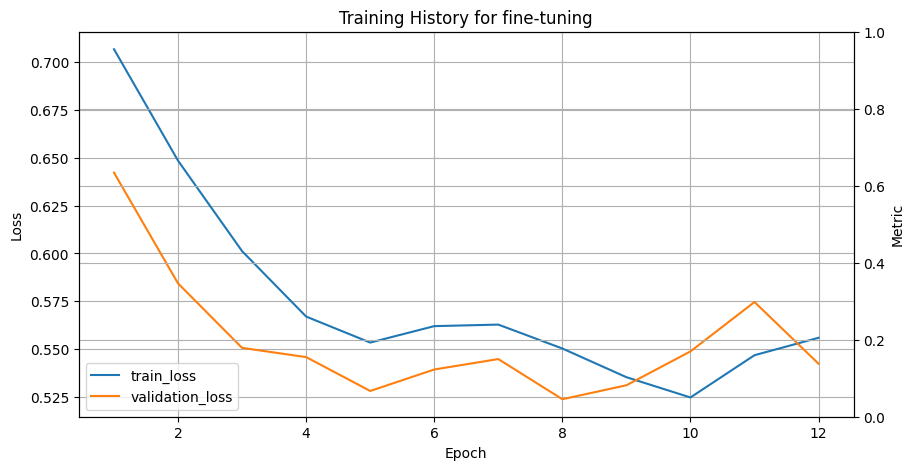

In [14]:
# Get loss, val_loss, and the computed metric from history
loss = [x['loss'] for x in history if 'loss' in x]
val_loss = [x['eval_loss'] for x in history if 'eval_loss' in x]

# Truncate the longer list to the size of the shorter one
min_length = min(len(loss), len(val_loss))
loss = loss[:min_length]
val_loss = val_loss[:min_length]

# Get spearman (for regression) or accuracy value (for classification)
if [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x] != []:
    metric = [x['eval_spearmanr'] for x in history if 'eval_spearmanr' in x]
else:
    metric = [x['eval_accuracy'] for x in history if 'eval_accuracy' in x]

epochs = [x['epoch'] for x in history if 'loss' in x]

# Create a figure with two y-axes
fig, ax1 = plt.subplots(figsize=(10, 5))
ax2 = ax1.twinx()

# Plot loss and val_loss on the first y-axis
line1 = ax1.plot(epochs, loss, label='train_loss')
line2 = ax1.plot(epochs, val_loss, label='validation_loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')

# Plot the computed metric on the second y-axis
#line3 = ax2.plot(epochs, metric, color='red', label='validation_metric')
ax2.set_ylabel('Metric')
ax2.set_ylim([0, 1])

# Add grid lines
ax1.grid(True)
ax2.grid(True)

# Combine the lines from both y-axes and create a single legend
lines = line1 + line2 
labels = [line.get_label() for line in lines]
ax1.legend(lines, labels, loc='lower left')

# Show the plot
plt.title("Training History for fine-tuning")
plt.savefig(f"../Plots/Without_3rdline_Training_History_new.pdf")
plt.show()

lr 0.0003459380673689418
batch 4
accum 4
dropout_rate 0.6303139405233136
weight_decay 7.145415686725527e-05
warmup_pct 0.12121786012551566
lora_rank 20
lora_init_scale 0.004413381171295235
lora_scaling_rank 3

In [15]:
def save_model(model,filepath):
# Saves all parameters that were changed during finetuning

    # Create a dictionary to hold the non-frozen parameters
    non_frozen_params = {}

    # Iterate through all the model parameters
    for param_name, param in model.named_parameters():
        # If the parameter has requires_grad=True, add it to the dictionary
        if param.requires_grad:
            non_frozen_params[param_name] = param

    # Save only the finetuned parameters 
    torch.save(non_frozen_params, filepath)

    
def load_model(filepath, num_labels=2):
# Creates a new PT5 model and loads the finetuned weights from a file

    # load a new model
    model, tokenizer = ESM_classification_model(num_labels=num_labels, dropout=0.6303139405233136, lora_rank=20, lora_init_scale=0.004413381171295235, lora_scaling_rank=3)
    # model_checkpoint = "facebook/esm2_t36_3B_UR50D"
    # tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
    # model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=2, cache_dir="/home/ubuntu/data/hai/huggingface_cache/", force_download=True)
    
    # Load the non-frozen parameters from the saved file
    non_frozen_params = torch.load(filepath)

    # Assign the non-frozen parameters to the corresponding parameters of the model
    for param_name, param in model.named_parameters():
        if param_name in non_frozen_params:
            param.data = non_frozen_params[param_name].data

    return tokenizer, model

In [16]:
# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_all_esm2.pth",num_labels=2)

/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Loading checkpoint shards: 100%|██████████████████████████████████████████████████████| 2/2 [00:09<00:00,  4.55s/it]
Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t36_3B_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ESM_LoRA_Classfier
Trainable Parameter: 2848188324.0
ESM_LoRA_Classfier
Trainable Parameter: 6561283.0



In [17]:
# Put both models to the same device
model=model.to("cpu")
model_reload=model_reload.to("cpu")

# Iterate through the parameters of the two models and compare the data
for param1, param2 in zip(model.parameters(), model_reload.parameters()):
    if not torch.equal(param1.data, param2.data):
        print("Models have different weights")
        break
else:
    print("Models have identical weights")

Models have different weights


In [18]:
from Bio import SeqIO
import pandas as pd

sequences = []

local_fasta_path = '../src/input_datasets/test_Pos_Neg_ST.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])
    
local_fasta_path = '../src/input_datasets/test_Pos_Neg_Y.fasta'

# Load FASTA file using Biopython
for record in SeqIO.parse(local_fasta_path, "fasta"):
    # Split the description to extract label
    description_parts = record.description.split("%")
    label = int(description_parts[-1].split("LABEL=")[1])  # Extracting the numeric part of the label
    sequences.append([record.name, str(record.seq), label])

# Create dataframe
df = pd.DataFrame(sequences, columns=["name", "sequence", "label"])

# Display the dataframe
df.head(5)


,name,sequence,label
0,sp|Q8WUI4|HDAC7_HUMAN%342%358,ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM,1
1,sp|Q13950|RUNX2_HUMAN%416%432,THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG,1
2,sp|Q15796|SMAD2_HUMAN%229%245,DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL,1
3,sp|P05787|K2C8_HUMAN%416%432,TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG,1
4,sp|Q92736|RYR2_HUMAN%2798%2814,MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN,1


In [19]:
my_test=df[["sequence", "label"]]

print(my_test.head(5))

'''
my_test["sequence"]=my_test["sequence"].str.replace('|'.join(["O","B","U","Z"]),"X",regex=True)
my_test['sequence']=my_test.apply(lambda row : " ".join(row["sequence"]), axis = 1)
'''

#Using .loc ensures that you are modifying the original DataFrame rather than a view of it, which helps avoid the SettingWithCopyWarning.
# Replace characters in the "sequence" column
my_test.loc[:, "sequence"] = my_test["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)

# Convert each sequence to a space-separated string
my_test.loc[:, 'sequence'] = my_test.apply(lambda row: " ".join(row["sequence"]), axis=1)


                            sequence  label
0  ERLSGSGLHWPLSRTRSEPLPPSATAPPPPGPM      1
1  THYHTYLPPPYPGSSQSQSGPFQTSSTPYLYYG      1
2  DGETSDQQLNQSMDTGSPAELSPTTLSPVNHSL      1
3  TSGYAGGLSSAYGGLTSPGLSYSLGSSFGSGAG      1
4  MALYNRTRRISQTSQVSVDAAHGYSPRAIDMSN      1


In [20]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = sequence.split()
    middle_index = len(chars) // 2
    return chars[middle_index]

# Apply the function to get the middle characters
my_test['middle_char'] = my_test['sequence'].apply(get_middle_char)

# Split the DataFrame
my_test_S = my_test[my_test['middle_char'] == 'S'].drop(columns=['middle_char'])
my_test_T = my_test[my_test['middle_char'] == 'T'].drop(columns=['middle_char'])
my_test_Y = my_test[my_test['middle_char'] == 'Y'].drop(columns=['middle_char'])
my_test_ST = my_test[my_test['middle_char'].isin(['S', 'T'])].drop(columns=['middle_char'])

In [21]:
my_test = my_test_Y

In [22]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|█████████████████████████████████████████████████████████████████████████████████| 4/4 [00:01<00:00,  3.77it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.762821 |      0.846154 |      0.916667 |       0.88 |  0.956731 |
+----------+---------------+---------------+------------+-----------+
[[22  4]
 [ 2 22]]


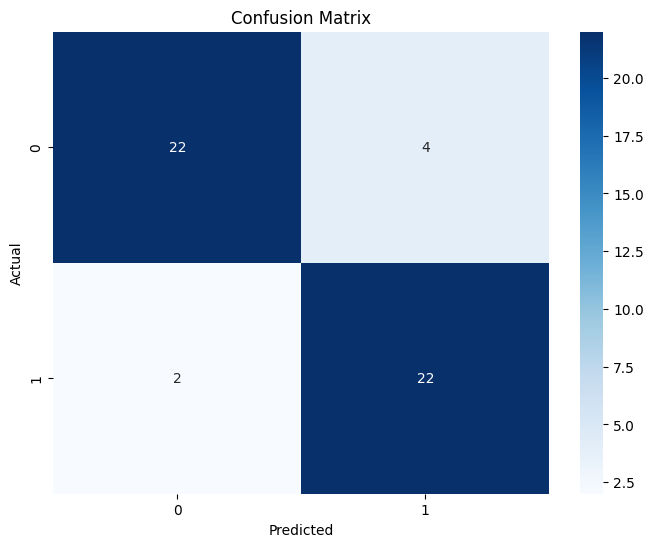

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

# Define class labels
class_labels = ['0', '1']

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"../Plots/Confusion_matrix_for_dephos_new.pdf")
plt.show()


In [24]:
my_test = my_test_ST

In [25]:
from sklearn.metrics import confusion_matrix, matthews_corrcoef, roc_auc_score
from tabulate import tabulate

# Set the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model_reload.to(device)

# create Dataset
test_set=create_dataset(tokenizer,list(my_test['sequence']),list(my_test['label']))
# make compatible with torch DataLoader
test_set = test_set.with_format("torch", device=device)

# Create a dataloader for the test dataset
test_dataloader = DataLoader(test_set, batch_size=16, shuffle=False)

# Put the model in evaluation mode
model_reload.eval()

# Make predictions on the test dataset
raw_logits = []
labels = []
with torch.no_grad():
    for batch in tqdm(test_dataloader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        # add batch results (logits) to predictions
        raw_logits += model_reload(input_ids, attention_mask=attention_mask).logits.tolist()
        labels += batch["labels"].tolist()

# Convert logits to predictions
raw_logits = np.array(raw_logits)
predictions = np.argmax(raw_logits, axis=1)

# Calculate metrics
conf_matrix = confusion_matrix(labels, predictions)
tn, fp, fn, tp = conf_matrix.ravel()

mcc = matthews_corrcoef(labels, predictions)
specificity = tn / (tn + fp)
sensitivity = tp / (tp + fn)
accuracy = accuracy_score(labels, predictions)
roc_auc = roc_auc_score(labels, raw_logits[:, 1])  # Assuming binary classification, adjust accordingly


metrics_table = [
    ["MCC", "Specificity", "Sensitivity", "Accuracy", "ROC-AUC"],
    [mcc, specificity, sensitivity, accuracy, roc_auc]
]

print(tabulate(metrics_table, headers="firstrow", tablefmt="grid"))
print(conf_matrix)


100%|███████████████████████████████████████████████████████████████████████████████| 28/28 [00:08<00:00,  3.29it/s]

+----------+---------------+---------------+------------+-----------+
|      MCC |   Specificity |   Sensitivity |   Accuracy |   ROC-AUC |
+==========+===============+===============+============+===========+
| 0.536105 |        0.6875 |      0.842342 |   0.764574 |  0.854448 |
+----------+---------------+---------------+------------+-----------+
[[154  70]
 [ 35 187]]


In [20]:
import umap

def apply_umap(embeddings, n_components=2, n_neighbors=5, min_dist=0.01, metric='euclidean'):
    umap_model = umap.UMAP(
        n_components=n_components,
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        metric=metric
    )
    umap_embeddings = umap_model.fit_transform(embeddings)
    return umap_embeddings

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_umap(embeddings, labels):
    df = pd.DataFrame({
        "UMAP1": embeddings[:, 0],
        "UMAP2": embeddings[:, 1],
        "Label": labels
    })
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(
        x="UMAP1", y="UMAP2", hue="Label", data=df, palette={0: "blue", 1: "magenta"}, s=50, alpha=0.9
    )
    plt.title("UMAP Visualization of Embeddings")
    plt.legend(title='Label', bbox_to_anchor=(1.05, 1), loc=2)
    plt.savefig("../Plots/UMAP_Visualization_of_Embeddings_ST.pdf", bbox_inches='tight')
    plt.show()
    
def get_embeddings(model, tokenizer, sequences, batch_size=32, device="cuda"):
    embeddings = []
    model = model.to(device)
    model.eval()

    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i + batch_size]
        inputs = tokenizer(batch, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)

        with torch.no_grad():
            outputs = model(**inputs)
            hidden_states = outputs.hidden_states[-2].detach().cpu().numpy()
            embeddings.extend(hidden_states[:, 0, :])

        print(f"Processed batch {i // batch_size + 1}/{len(sequences) // batch_size + 1}")

    return np.array(embeddings)

In [38]:
# Function to get the middle character
def get_middle_char(sequence):
    chars = list(sequence)
    middle_index = len(chars) // 2
    return chars[middle_index]

valid_df = df

# Apply the function to get the middle characters
valid_df['middle_char'] = valid_df['sequence'].apply(get_middle_char)

valid_df = valid_df[valid_df['middle_char'] == 'T'].drop(columns=['middle_char'])

In [39]:
valid_df

,name,sequence,label
180,sp|Q9GZM8|NDEL1_HUMAN%203%219,CEKMDSAVQASLSLPATPVGKGTENTFPSPKAI,1
181,sp|Q8N163|CCAR2_HUMAN%438%454,EWEALCQQKAAEAAPPTQEAQGETEPTEQAPDA,1
182,sp|P10636-8|TAU_HUMAN%196%212,GYSSPGSPGTPGSRSRTPSLPTPPTREPKKVAV,1
183,sp|Q02241|KIF23_HUMAN%434%450,QEVEVARPVDKAICGLTPGRRYRNQPRGPVGNE,1
184,sp|Q04206|TF65_HUMAN%419%435,QAVAPPAPKPTQAGEGTLSEALLQLQFDDEDLG,1
...,...,...,...
441,sp|Q76N33|STALP_MOUSE%326%342,ENVEELFNVQDQHGLLTLGWIHTHPTQTAFLSS,0
442,sp|P49790|NU153_HUMAN%1098%1114,FVLGRTEEKQQEPVTSTSLVFGKKADNEEPKCQ,0
443,sp|Q8NFC6|BD1L1_HUMAN%2789%2805,DVLDSRIETAQRQCPETEPHDTKEENSRDLEEL,0
444,sp|Q5T6F2|UBAP2_HUMAN%514%530,SKIPASAVEMPGSADVTGLNVQFGALEFGSEPS,0


/home/ubuntu/data/miniconda3/envs/finetune-dephos/lib/python3.9/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


ProtT5_Classfier
Trainable Parameter: 1209193475.0
ProtT5_LoRA_Classfier
Trainable Parameter: 3559427.0

Processed batch 1/3
Processed batch 2/3
Processed batch 3/3


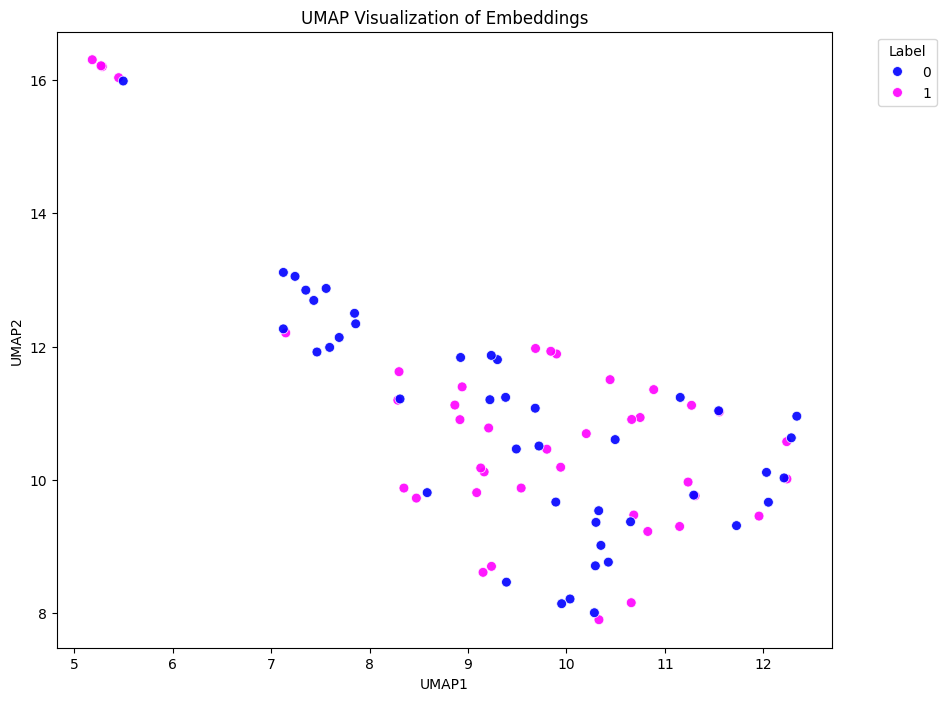

In [40]:
# valid_df = my_valid

# tokenizer, model_reload = load_model("../finetuned_model.pth", num_labels=2)
tokenizer, model_reload = load_model("model_output/finetuned_model_ST.pth",num_labels=2)

valid_df["sequence"] = valid_df["sequence"].str.replace('|'.join(["O", "B", "U", "Z"]), "X", regex=True)
valid_df["sequence"] = valid_df["sequence"].apply(lambda x: " ".join(x))

valid_sequences = list(valid_df['sequence'])
valid_embeddings = get_embeddings(model_reload, tokenizer, valid_sequences)

umap_embeddings = apply_umap(valid_embeddings)


labels = list(valid_df['label'])

plot_umap(umap_embeddings, labels)
